In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from functools import reduce
from collections import Counter
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import networkx as nx
import igraph as ig
from networkx.algorithms import community
from networkx.algorithms.community.quality import modularity

In [2]:
df_1200_1400= pd.read_csv("../data/processed/chess_data_1200-1400_full.csv")
df_1400_1600= pd.read_csv("../data/processed/chess_data_1400-1600_full.csv")
df_1600_1800= pd.read_csv("../data/processed/chess_data_1600-1800_full.csv")

# Analisis exploratorio de los datos

In [3]:
## Quedaron columnas con nulos?
def print_null_counts(df, nombre_df):
    print(f"\nEn {nombre_df}:")
    for col in df.columns:
        nulos = df[col].isnull().sum()
        no_nulos = df[col].notnull().sum()
        print(f"Columna '{col}': nulos = {nulos}, no nulos = {no_nulos}")

print_null_counts(df_1200_1400, "df_1200_1400")
print_null_counts(df_1400_1600, "df_1400_1600")
print_null_counts(df_1600_1800, "df_1600_1800")



En df_1200_1400:
Columna 'game_id': nulos = 0, no nulos = 345739
Columna 'white_player': nulos = 0, no nulos = 345739
Columna 'black_player': nulos = 0, no nulos = 345739
Columna 'white_elo': nulos = 0, no nulos = 345739
Columna 'black_elo': nulos = 0, no nulos = 345739
Columna 'elo_group': nulos = 0, no nulos = 345739
Columna 'opening': nulos = 0, no nulos = 345739
Columna 'eco': nulos = 0, no nulos = 345739
Columna 'time_control': nulos = 0, no nulos = 345739
Columna 'tipo_de_partida': nulos = 0, no nulos = 345739
Columna 'opening_sequence': nulos = 256, no nulos = 345483
Columna 'file_tag': nulos = 0, no nulos = 345739

En df_1400_1600:
Columna 'game_id': nulos = 0, no nulos = 468910
Columna 'white_player': nulos = 0, no nulos = 468910
Columna 'black_player': nulos = 0, no nulos = 468910
Columna 'white_elo': nulos = 0, no nulos = 468910
Columna 'black_elo': nulos = 0, no nulos = 468910
Columna 'elo_group': nulos = 0, no nulos = 468910
Columna 'opening': nulos = 0, no nulos = 468910

### Cantidad de partidas

In [4]:
#Cantidad de partidas por rango de ELO
print(f'{df_1200_1400.shape}, {df_1400_1600.shape}, {df_1600_1800.shape}')

(345739, 12), (468910, 12), (414393, 12)


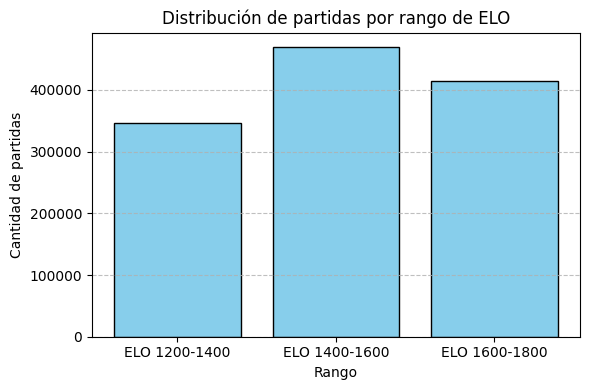

In [5]:
#Cantidad de partidas por rango de ELO
cantidad = [
    df_1200_1400.shape[0],
    df_1400_1600.shape[0],
    df_1600_1800.shape[0]
]

rango_elo = ['ELO 1200-1400', 'ELO 1400-1600', 'ELO 1600-1800']

plt.figure(figsize=(6, 4))
plt.bar(rango_elo, cantidad, color='skyblue', edgecolor='black')
plt.xlabel('Rango')
plt.ylabel('Cantidad de partidas')
plt.title('Distribución de partidas por rango de ELO')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

### Cantidad de jugadores distintos y cantidad de aperturas distintas en cada dataset

C:\Users\Federico\AppData\Local\Temp\ipykernel_5036\387550472.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  jugadores = pd.unique(df['white_player'].tolist() + df['black_player'].tolist())


Rango ELO 1200-1400: 38128 jugadores distintos, 366 aperturas distintas
Rango ELO 1400-1600: 48516 jugadores distintos, 427 aperturas distintas
Rango ELO 1600-1800: 33659 jugadores distintos, 466 aperturas distintas


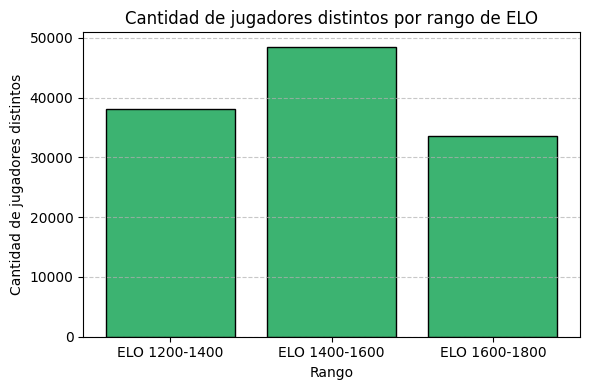

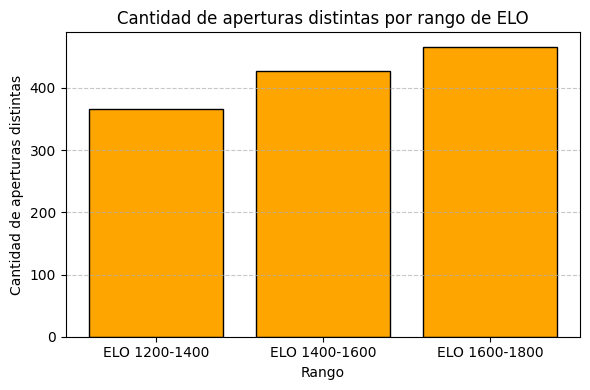

In [6]:
dfs = [df_1200_1400, df_1400_1600, df_1600_1800]
rango_elo = ['ELO 1200-1400', 'ELO 1400-1600', 'ELO 1600-1800']
jugadores_distintos = []
aperturas_distintas = []

for df in dfs:
    jugadores = pd.unique(df['white_player'].tolist() + df['black_player'].tolist())
    jugadores_distintos.append(len(jugadores))
    aperturas_distintas.append(df['eco'].nunique())

for i, rango in enumerate(rango_elo):
    print(f'Rango {rango}: {jugadores_distintos[i]} jugadores distintos, {aperturas_distintas[i]} aperturas distintas')

plt.figure(figsize=(6,4))
plt.bar(rango_elo, jugadores_distintos, color='mediumseagreen', edgecolor='black')
plt.xlabel('Rango')
plt.ylabel('Cantidad de jugadores distintos')
plt.title('Cantidad de jugadores distintos por rango de ELO')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.bar(rango_elo, aperturas_distintas, color='orange', edgecolor='black')
plt.xlabel('Rango')
plt.ylabel('Cantidad de aperturas distintas')
plt.title('Cantidad de aperturas distintas por rango de ELO')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Cantidad de aperturas totales

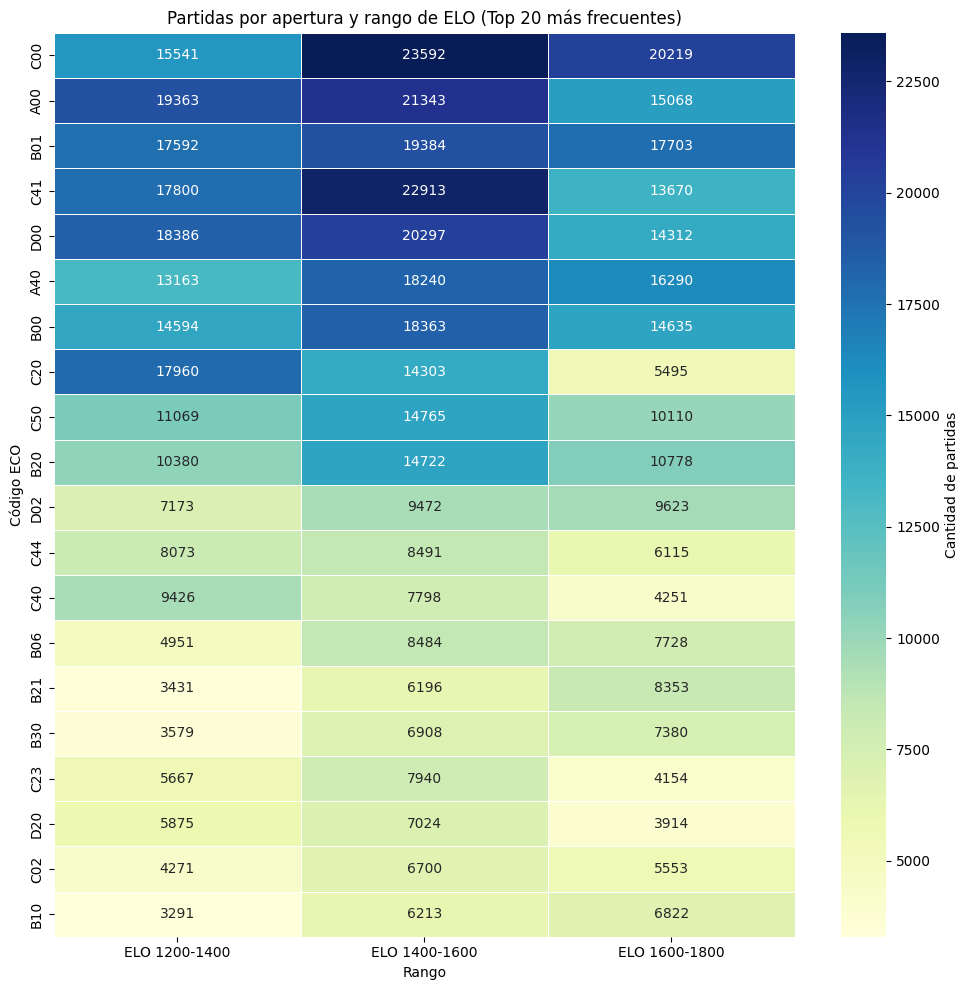

In [7]:
def contar_aperturas(df, suffix):
    return (
        df.groupby("eco")["game_id"]
        .nunique()
        .reset_index(name=f"count_{suffix}")
    )

# Lista de DataFrames y sus sufijos correspondientes
dfs = [
    (df_1200_1400, "1200_1400"),
    (df_1400_1600, "1400_1600"),
    (df_1600_1800, "1600_1800")
]

counts = [contar_aperturas(df, suffix) for df, suffix in dfs]

common_openings = reduce(
    lambda left, right: pd.merge(left, right, on="eco", how="inner"),
    counts
)

count_columns = [f"count_{suffix}" for _, suffix in dfs]
common_openings["total"] = common_openings[count_columns].sum(axis=1)

# Ordenar por total de partidas y tomar las 20 más frecuentes
top_openings = common_openings.sort_values(by="total", ascending=False).head(20)

# Reorganizar el DataFrame para el heatmap
df_heatmap = top_openings.set_index("eco")[
    ["count_1200_1400", "count_1400_1600", "count_1600_1800"]
]
df_heatmap.columns = ['ELO 1200-1400', 'ELO 1400-1600', 'ELO 1600-1800']

plt.figure(figsize=(10, max(6, len(df_heatmap) * 0.5)))
sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Cantidad de partidas"})
plt.title("Partidas por apertura y rango de ELO (Top 20 más frecuentes)")
plt.xlabel("Rango")
plt.ylabel("Código ECO")
plt.tight_layout()
plt.show()

In [8]:
# Hay aperturas que no se pudieron clasificar en cada grupo de ELO
dfs = [
    (df_1200_1400, "1200_1400"),
    (df_1400_1600, "1400_1600"),
    (df_1600_1800, "1600_1800")
]

for df, suffix in dfs:
    cantidad_no_clasificadas = (df["eco"] == "?").sum()
    print(f'Cantidad de aperturas no clasificadas ("?") en el grupo {suffix}: {cantidad_no_clasificadas}')
plt.show()

Cantidad de aperturas no clasificadas ("?") en el grupo 1200_1400: 256
Cantidad de aperturas no clasificadas ("?") en el grupo 1400_1600: 811
Cantidad de aperturas no clasificadas ("?") en el grupo 1600_1800: 733


# Resultados


## Seleccion de partidas y jugadores, para luego analizar cantidad de partidas

In [9]:
# Elimino las partidas con ECO no asignado 
df_1200_1400 = df_1200_1400[df_1200_1400["eco"] != "?"]
df_1400_1600 = df_1400_1600[df_1400_1600["eco"] != "?"]
df_1600_1800 = df_1600_1800[df_1600_1800["eco"] != "?"]

## Logica de la seleccion

* Primero me quedo con las aperturas mas representativas, para eso:
1) Cuento cuales son las aperturas mas jugadas
2) Calculo el total de las aperturas. 
3) Calculo el total acumulado de las aperturas y lo divido por el total de las partidas. De esta forma, normalizo estos valores para que representen proporciones. Por ejemplo, si el 70% de las partidas se acumulan en las primeras pocas aperturas, esas aperturas son las más representativas. 

Para cada grupo de jugadores, tendre la misma cantidad de partidas luego de normalizar y filtrar?

* Segundo, tengo que realizar una seleccion de jugadores, no quiero jugadores que en 3 meses hayan jugado menos de 50 partidas ni jugadores que hayan jugado mas de 200. 

Cuantos jugadores exclui al realizar este analisis?


In [10]:
unicas_1200_1400 = df_1200_1400['eco'].nunique()
unicas_1400_1600 = df_1400_1600['eco'].nunique()
unicas_1600_1800 = df_1600_1800['eco'].nunique()

print(f'Cantidad de aperturas distintas antes de filtrar: \n Elo 1200-1400: {unicas_1200_1400} \n Elo 1400-1600: {unicas_1400_1600} \n Elo 1600-1800: {unicas_1600_1800}')

Cantidad de aperturas distintas antes de filtrar: 
 Elo 1200-1400: 365 
 Elo 1400-1600: 426 
 Elo 1600-1800: 465


In [11]:
def aperturas_representativas(df): 
    eco_counts = df['eco'].value_counts()
    total_partidas = eco_counts.sum()
    eco_cumsum = eco_counts.cumsum() / total_partidas
    eco_70 = eco_cumsum[eco_cumsum <= 0.7].index.tolist()
    df = df[df['eco'].isin(eco_70)]
    return df

In [12]:
df_1200_1400=aperturas_representativas(df_1200_1400)
df_1400_1600=aperturas_representativas(df_1400_1600)
df_1600_1800=aperturas_representativas(df_1600_1800)

In [13]:
unicas_1200_1400 = df_1200_1400['eco'].nunique()
unicas_1400_1600 = df_1400_1600['eco'].nunique()
unicas_1600_1800 = df_1600_1800['eco'].nunique()

print(f'Cantidad de aperturas distintas despues de filtrar: \n Elo 1200-1400: {unicas_1200_1400} \n Elo 1400-1600: {unicas_1400_1600} \n Elo 1600-1800: {unicas_1600_1800}')

Cantidad de aperturas distintas despues de filtrar: 
 Elo 1200-1400: 26 
 Elo 1400-1600: 33 
 Elo 1600-1800: 42


In [14]:
# contar cantidad de jugadores para cada df antes de filtrar 
j_blancos_1200_1400 = df_1200_1400['white_player'].nunique()
j_negros_1200_1400 = df_1200_1400['black_player'].nunique()
jugadores_unicos_1200_1400 = j_blancos_1200_1400 + j_negros_1200_1400
j_blancos_1400_1600 = df_1400_1600['white_player'].nunique()
j_negros_1400_1600 = df_1400_1600['black_player'].nunique()
jugadores_unicos_1400_1600 = j_blancos_1400_1600 + j_negros_1400_1600
j_blancos_1600_1800 = df_1600_1800['white_player'].nunique()
j_negros_1600_1800 = df_1600_1800['black_player'].nunique()
jugadores_unicos_1600_1800 = j_blancos_1600_1800 + j_negros_1600_1800

print(f'Cantidad de jugadores distintos antes de filtrar: \n Elo 1200-1400: {jugadores_unicos_1200_1400} \n Elo 1400-1600: {jugadores_unicos_1400_1600} \n Elo 1600-1800: {jugadores_unicos_1600_1800}')


Cantidad de jugadores distintos antes de filtrar: 
 Elo 1200-1400: 54734 
 Elo 1400-1600: 67813 
 Elo 1600-1800: 51338


In [15]:
def filtro_jugadores(df):
    # Contar partidas como blancas y negras por separado
    jugadores_blancas_counts = df['white_player'].value_counts()
    jugadores_negras_counts = df['black_player'].value_counts()
    
    # Filtrar jugadores con más de 100 y menos de 200 partidas en cada color
    jugadores_seleccionados = jugadores_blancas_counts[
        (jugadores_blancas_counts > 50) & (jugadores_blancas_counts < 300) &
        (jugadores_negras_counts > 50) & (jugadores_negras_counts < 300)
    ].index.tolist()
    # Filtrar el DataFrame original
    df = df[
        df['white_player'].isin(jugadores_seleccionados) & 
        df['black_player'].isin(jugadores_seleccionados)
    ]
    return df

In [16]:
df_1200_1400=filtro_jugadores(df_1200_1400)
df_1400_1600=filtro_jugadores(df_1400_1600)
df_1600_1800=filtro_jugadores(df_1600_1800)

In [17]:
# contar cantidad de jugadores para cada df despues de filtrar
j_blancos_1200_1400 = df_1200_1400['white_player'].nunique()
j_negros_1200_1400 = df_1200_1400['black_player'].nunique()
jugadores_unicos_1200_1400 = j_blancos_1200_1400 + j_negros_1200_1400
j_blancos_1400_1600 = df_1400_1600['white_player'].nunique()
j_negros_1400_1600 = df_1400_1600['black_player'].nunique()
jugadores_unicos_1400_1600 = j_blancos_1400_1600 + j_negros_1400_1600
j_blancos_1600_1800 = df_1600_1800['white_player'].nunique()
j_negros_1600_1800 = df_1600_1800['black_player'].nunique()
jugadores_unicos_1600_1800 = j_blancos_1600_1800 + j_negros_1600_1800

print(f'Cantidad de jugadores distintos despues de filtrar: \n Elo 1200-1400: {jugadores_unicos_1200_1400} \n Elo 1400-1600: {jugadores_unicos_1400_1600} \n Elo 1600-1800: {jugadores_unicos_1600_1800}')


Cantidad de jugadores distintos despues de filtrar: 
 Elo 1200-1400: 1140 
 Elo 1400-1600: 1941 
 Elo 1600-1800: 1848


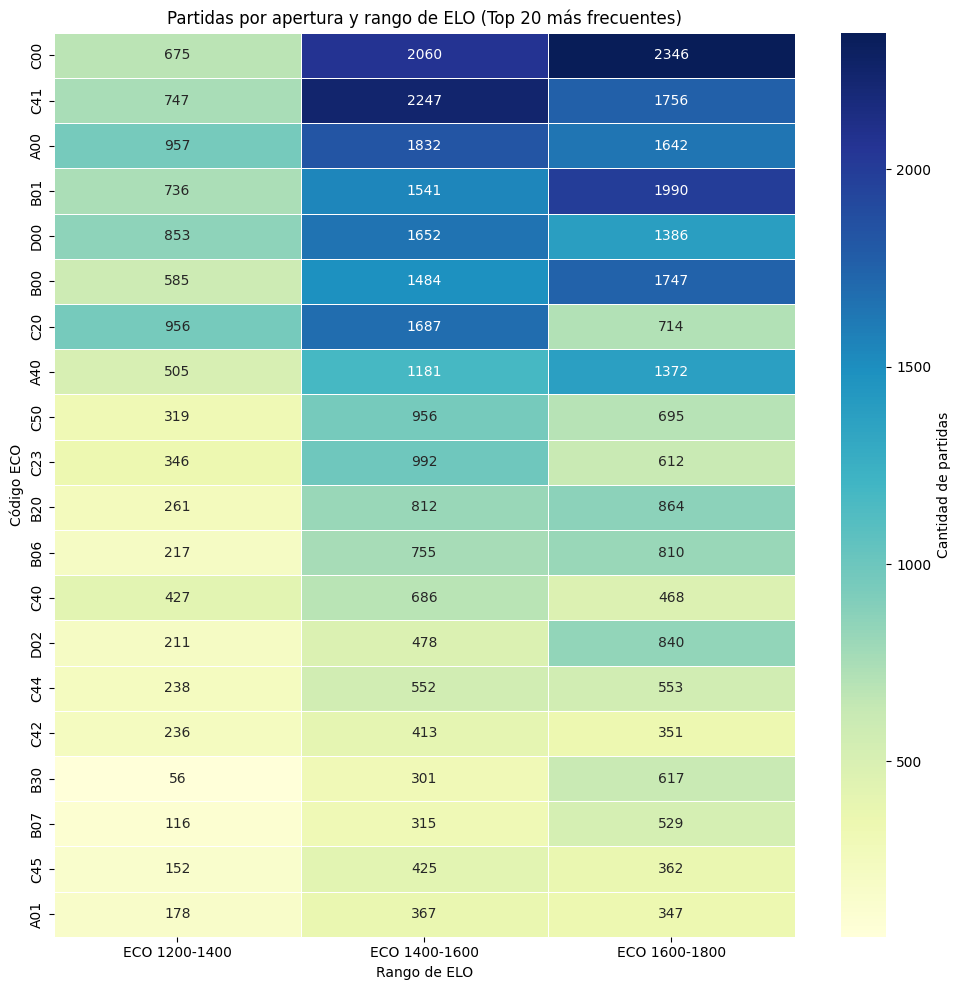

In [19]:
# Lista de DataFrames y sus sufijos correspondientes
dfs = [
    (df_1200_1400, "1200_1400"),
    (df_1400_1600, "1400_1600"),
    (df_1600_1800, "1600_1800")
]

counts = [contar_aperturas(df, suffix) for df, suffix in dfs]

common_openings = reduce(
    lambda left, right: pd.merge(left, right, on="eco", how="inner"),
    counts
)

count_columns = [f"count_{suffix}" for _, suffix in dfs]
common_openings["total"] = common_openings[count_columns].sum(axis=1)

# Ordenar por total de partidas y tomar las 20 más frecuentes
top_openings = common_openings.sort_values(by="total", ascending=False).head(20)

# Reorganizar el DataFrame para el heatmap
df_heatmap = top_openings.set_index("eco")[
    ["count_1200_1400", "count_1400_1600", "count_1600_1800"]
]
df_heatmap.columns = ['ECO 1200-1400', 'ECO 1400-1600', 'ECO 1600-1800']

plt.figure(figsize=(10, max(6, len(df_heatmap) * 0.5)))
sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Cantidad de partidas"})
plt.title("Partidas por apertura y rango de ELO (Top 20 más frecuentes)")
plt.xlabel("Rango de ELO")
plt.ylabel("Código ECO")
plt.tight_layout()
plt.show()

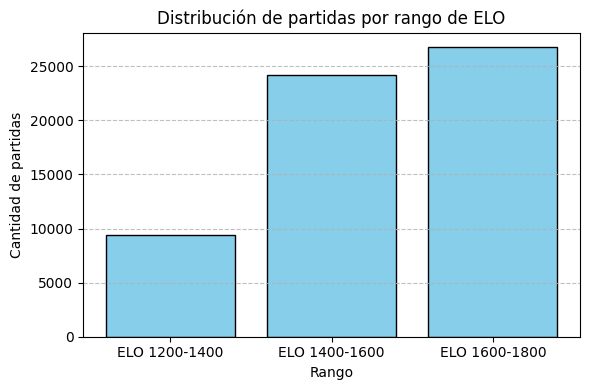

In [20]:
#Cantidad de partidas por rango de ELO
cantidad = [
    df_1200_1400.shape[0],
    df_1400_1600.shape[0],
    df_1600_1800.shape[0]
]

rango_elo = ['ELO 1200-1400', 'ELO 1400-1600', 'ELO 1600-1800']

plt.figure(figsize=(6, 4))
plt.bar(rango_elo, cantidad, color='skyblue', edgecolor='black')
plt.xlabel('Rango')
plt.ylabel('Cantidad de partidas')
plt.title('Distribución de partidas por rango de ELO')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

## Me quedo con 9000 partidas de cada grupo de ELO

In [23]:
def stratified_sample_by_eco(df, n=9000, random_state=42):
    if len(df) <= n:
        return df.copy()
    df_sample, _ = train_test_split(
        df,
        train_size=n,
        stratify=df['eco'],
        random_state=random_state
    )
    return df_sample

df_1200_1400 = stratified_sample_by_eco(df_1200_1400, n=9000)
df_1400_1600= stratified_sample_by_eco(df_1400_1600, n=9000)
df_1600_1800= stratified_sample_by_eco(df_1600_1800, n=9000)

print(df_1200_1400.shape)
print(df_1400_1600.shape)
print(df_1600_1800.shape)

(9000, 12)
(9000, 12)
(9000, 12)


In [24]:
# contar cantidad de jugadores para cada df despues de filtrar
j_blancos_1200_1400 = df_1200_1400['white_player'].nunique()
j_negros_1200_1400 = df_1200_1400['black_player'].nunique()
jugadores_unicos_1200_1400 = j_blancos_1200_1400 + j_negros_1200_1400
j_blancos_1400_1600 = df_1400_1600['white_player'].nunique()
j_negros_1400_1600 = df_1400_1600['black_player'].nunique()
jugadores_unicos_1400_1600 = j_blancos_1400_1600 + j_negros_1400_1600
j_blancos_1600_1800 = df_1600_1800['white_player'].nunique()
j_negros_1600_1800 = df_1600_1800['black_player'].nunique()
jugadores_unicos_1600_1800 = j_blancos_1600_1800 + j_negros_1600_1800

print(f'Cantidad de jugadores distintos despues de filtrar: \n Elo 1200-1400: {jugadores_unicos_1200_1400} \n Elo 1400-1600: {jugadores_unicos_1400_1600} \n Elo 1600-1800: {jugadores_unicos_1600_1800}')


Cantidad de jugadores distintos despues de filtrar: 
 Elo 1200-1400: 1140 
 Elo 1400-1600: 1937 
 Elo 1600-1800: 1844


In [25]:
# Contar la cantidad de aperturas distintas (columna "eco") para cada df después de filtrar
aperturas_distintas_1200_1400 = df_1200_1400['eco'].nunique()
aperturas_distintas_1400_1600 = df_1400_1600['eco'].nunique()
aperturas_distintas_1600_1800 = df_1600_1800['eco'].nunique()

print(f'Cantidad de aperturas distintas después de filtrar: \n Elo 1200-1400: {aperturas_distintas_1200_1400} \n Elo 1400-1600: {aperturas_distintas_1400_1600} \n Elo 1600-1800: {aperturas_distintas_1600_1800}')


Cantidad de aperturas distintas después de filtrar: 
 Elo 1200-1400: 26 
 Elo 1400-1600: 33 
 Elo 1600-1800: 42


# Quiero tener de cada jugador la cantidad de veces que jugo una apertura ya sea con blancas o con negras. Habra una relacion entre el ELO de un jugador y la apertura que juega?

In [26]:
def crear_matriz_bipartita(df, nombre_variable=None, globals_dict=None):
    """
    Crea la matriz bipartita jugador-apertura para el DataFrame dado.
    Si se pasa nombre_variable y globals_dict, asigna la matriz resultante a ese nombre en el espacio global.
    Devuelve la matriz bipartita.
    """
    # Preparar dataframes para blancas y negras
    white = df[['white_player', 'eco']].rename(columns={'white_player': 'player'})
    white['color'] = 'W'
    black = df[['black_player', 'eco']].rename(columns={'black_player': 'player'})
    black['color'] = 'B'
    all_players = pd.concat([white, black])

    # Identificador único apertura+color
    all_players['eco_color'] = all_players['eco'] + '_' + all_players['color']

    # Matriz bipartita binaria (presencia/ausencia)
    matriz_bipartita = all_players.groupby(['player', 'eco_color']).size().gt(0).astype(int).unstack(fill_value=0)

    # Si se provee nombre_variable y globals_dict, asignar la matriz con ese nombre
    if nombre_variable is not None and globals_dict is not None:
        globals_dict[nombre_variable] = matriz_bipartita

    return matriz_bipartita

# Ejemplo de uso para mantener el nombre identificatorio:
matriz_bipartita_1200_1400 = crear_matriz_bipartita(df_1200_1400, nombre_variable='matriz_bipartita_1200_1400', globals_dict=globals())
matriz_bipartita_1400_1600 = crear_matriz_bipartita(df_1400_1600, nombre_variable='matriz_bipartita_1400_1600', globals_dict=globals())
matriz_bipartita_1600_1800 = crear_matriz_bipartita(df_1600_1800, nombre_variable='matriz_bipartita_1600_1800', globals_dict=globals())


In [29]:
matriz_bipartita_1600_1800.head()

eco_color,A00_B,A00_W,A01_B,A01_W,A02_B,A02_W,A04_B,A04_W,A40_B,A40_W,...,D02_B,D02_W,D06_B,D06_W,D10_B,D10_W,D20_B,D20_W,D30_B,D30_W
player,,,,,,,,,,,,,,,,,,,,,
A87144434784,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
AS72,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
ATTRV122I,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Aaallister,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AbbasAbbasIran,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


## **Red de Coocurrencia \( W* \) entre Aperturas**
 
 Una vez que tienes la matriz bipartita \( M \), puedes construir una red de afinidad entre aperturas. En esta red, dos aperturas están conectadas si muchos jugadores han utilizado ambas.
 
 El producto \( M^T \times M \) es una forma estándar de obtener la matriz de coocurrencias en redes bipartitas. Cada elemento \((o1, o2)\) indica cuántos jugadores comparten ambas aperturas.
 


In [34]:
def obtener_mapeo_nodo_a_apertura(matriz_bipartita):
    """
    Dada una matriz bipartita, devuelve un diccionario que mapea cada nodo a su apertura correspondiente.

    Args:
        matriz_bipartita (pd.DataFrame): Matriz bipartita con columnas representando aperturas.

    Returns:
        dict: Diccionario donde las claves son índices de nodos y los valores son nombres de aperturas.
    """
    aperturas = list(matriz_bipartita.columns)  # Lista de nombres de aperturas en el mismo orden que los nodos
    nodo_a_apertura = {i: apertura for i, apertura in enumerate(aperturas)}
    return nodo_a_apertura

# Ejemplo de uso con una matriz específica
nodo_a_apertura_1200_1400 = obtener_mapeo_nodo_a_apertura(matriz_bipartita_1200_1400)
nodo_a_apertura_1400_1600 = obtener_mapeo_nodo_a_apertura(matriz_bipartita_1400_1600)
nodo_a_apertura_1600_1800 = obtener_mapeo_nodo_a_apertura(matriz_bipartita_1600_1800)

In [32]:
# ## un formato mas eficiente que el df
M_1200_1400 = csr_matrix(matriz_bipartita_1200_1400.values)
M_1400_1600 = csr_matrix(matriz_bipartita_1400_1600.values)
M_1600_1800 = csr_matrix(matriz_bipartita_1600_1800.values)

In [30]:
def simular_bipartito(M, n_sim=10, alpha=0.01, semilla=24, nodo_a_apertura=None):
    """
    Simula una red bipartita conservando los grados de jugadores y aperturas,
    y calcula la matriz de coocurrencia esperada bajo el modelo nulo.

    Args:
        M (csr_matrix): Matriz bipartita (jugadores x aperturas).
        n_sim (int): Número de simulaciones.
        alpha (float): Nivel de significancia para el filtrado.
        semilla (int): Semilla para reproducibilidad.
        nodo_a_apertura (dict or None): Diccionario {índice: nombre_apertura} donde el nombre tiene la nomenclatura ECO_W/ECO_B.

    Returns:
        W_filtrada (np.ndarray): Matriz de coocurrencia filtrada por significancia.
        W_real (np.ndarray): Matriz de coocurrencia real.
        pvalores (np.ndarray): Matriz de p-valores empíricos.
        mascara_valida (np.ndarray): Máscara booleana donde True indica pares válidos (no diagonal).
    """
    np.random.seed(semilla)
    num_jugadores, num_aperturas = M.shape
    W_real = M.T @ M  # Coocurrencias reales (aperturas x aperturas)
    W_real = W_real.toarray()

    # Guardo las simulaciones
    simulaciones = np.zeros((n_sim, num_aperturas, num_aperturas), dtype=int)

    grados_jugadores = np.array(M.sum(axis=1)).flatten()  # Grado de jugadores
    grados_aperturas = np.array(M.sum(axis=0)).flatten()  # Grado de aperturas

    # Chequeo de consistencia: los stubs deben coincidir
    if grados_jugadores.sum() != grados_aperturas.sum():
        raise ValueError(f"El número total de stubs de jugadores ({grados_jugadores.sum()}) "
                         f"no coincide con el de aperturas ({grados_aperturas.sum()})")

    for r in tqdm(range(n_sim), desc="Simulando bipartito"):
        # Listas de "stubs"
        stubs_jugadores = np.repeat(np.arange(num_jugadores), grados_jugadores)
        stubs_aperturas = np.repeat(np.arange(num_aperturas), grados_aperturas)

        # Mezclar los stubs
        np.random.shuffle(stubs_aperturas)
        np.random.shuffle(stubs_jugadores)

       
        # Si hay más stubs de un lado, recortar para igualar
        n_enlaces = min(len(stubs_jugadores), len(stubs_aperturas))
        enlaces = list(zip(stubs_jugadores[:n_enlaces], stubs_aperturas[:n_enlaces]))

        # Si no hay enlaces, saltar simulación
        if not enlaces:
            continue

        filas, columnas = zip(*enlaces)
        M_sim = csr_matrix((np.ones(len(enlaces)), (filas, columnas)), shape=(num_jugadores, num_aperturas))
        W_sim = M_sim.T @ M_sim
        simulaciones[r] = W_sim.toarray()

    # p-valor empírico para cada par
    pvalores = np.mean(simulaciones >= W_real[None, :, :], axis=0)


    mascara_valida = np.ones((num_aperturas, num_aperturas), dtype=bool)
    np.fill_diagonal(mascara_valida, False)

    # Filtrado por significancia y quitando la diagonal
    W_filtrada = (W_real * (pvalores < alpha) * mascara_valida).astype(int)

    return W_filtrada, W_real, pvalores, mascara_valida


In [35]:
W_1200_1400, W_real_1200_1400, pvals, nodo_a_apertura_1200_1400= simular_bipartito(M_1200_1400, n_sim=5000, alpha=0.05, semilla=42, nodo_a_apertura= nodo_a_apertura_1200_1400)

Simulando bipartito: 100%|██████████| 5000/5000 [00:33<00:00, 151.48it/s]


In [36]:
W_1400_1600, W_real_1400_1600, pvals, nodo_a_apertura_1400_1600= simular_bipartito(M_1400_1600, n_sim=5000, alpha=0.05, semilla=42, nodo_a_apertura= nodo_a_apertura_1400_1600)

Simulando bipartito: 100%|██████████| 5000/5000 [00:40<00:00, 124.16it/s]


In [37]:
W_1600_1800, W_real_1600_1800, pvals, nodo_a_apertura_1600_1800= simular_bipartito(M_1600_1800, n_sim=5000, alpha=0.05, semilla=42, nodo_a_apertura= nodo_a_apertura_1600_1800)

Simulando bipartito: 100%|██████████| 5000/5000 [00:43<00:00, 115.69it/s]


In [38]:
def graficar_mapas_calor_coocurrencia(matriz_real, matriz_filtrada, prefijo_titulo=''):
    figura, ejes = plt.subplots(1, 2, figsize=(16, 8))
    
    imagen0 = ejes[0].matshow(matriz_real, cmap='viridis')
    barra_color0 = figura.colorbar(imagen0, ax=ejes[0], shrink=0.8)
    barra_color0.set_label('Número de jugadores en común', rotation=270, labelpad=20)
    ejes[0].set_title(f'{prefijo_titulo} Coocurrencia observada', fontsize=14)
    ejes[0].tick_params(axis='both', which='major', labelsize=8)
    
    imagen1 = ejes[1].matshow(matriz_filtrada, cmap='viridis')
    barra_color1 = figura.colorbar(imagen1, ax=ejes[1], shrink=0.8)
    barra_color1.set_label('Número de jugadores en común', rotation=270, labelpad=20)
    ejes[1].set_title(f'{prefijo_titulo} Coocurrencia filtrada', fontsize=14)
    ejes[1].tick_params(axis='both', which='major', labelsize=8)
    
    plt.tight_layout()
    plt.show()

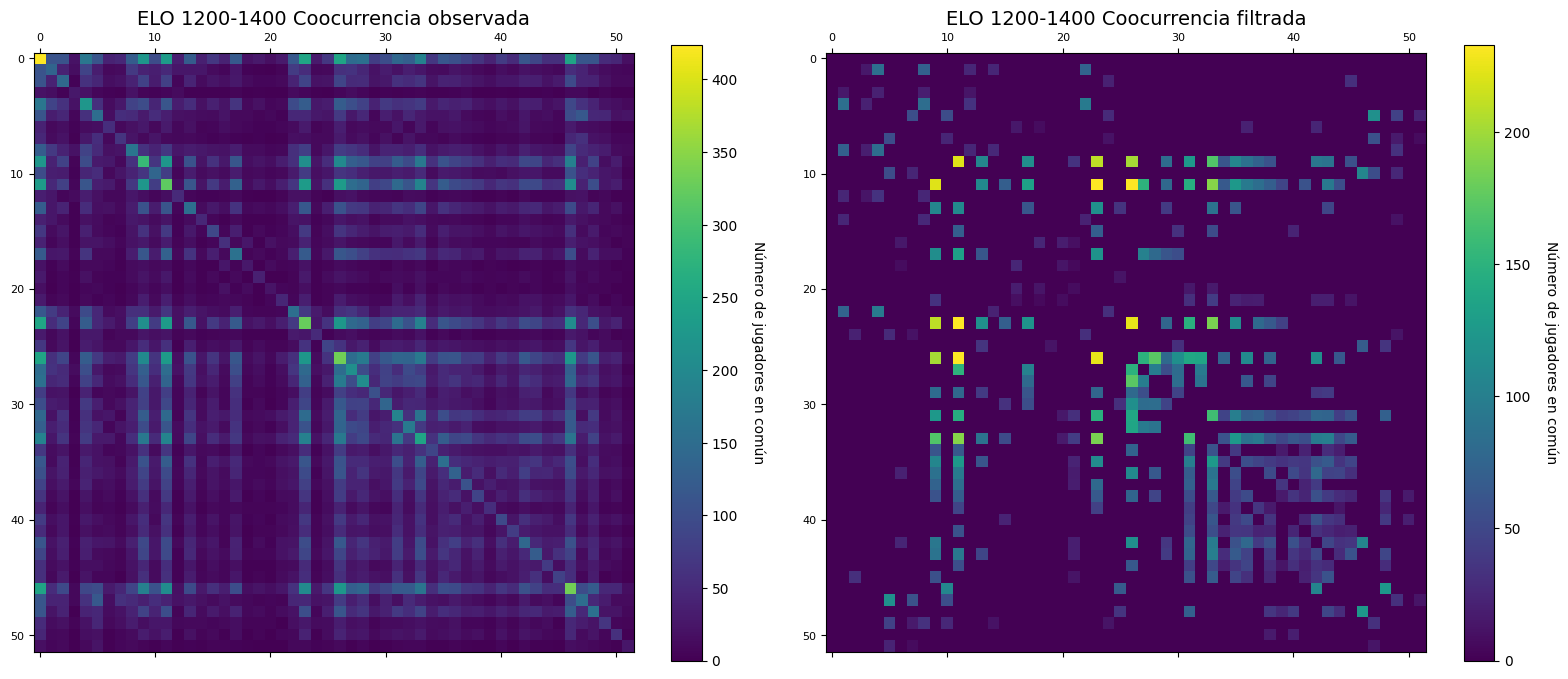

In [39]:
graficar_mapas_calor_coocurrencia(W_real_1200_1400, W_1200_1400 , prefijo_titulo="ELO 1200-1400")

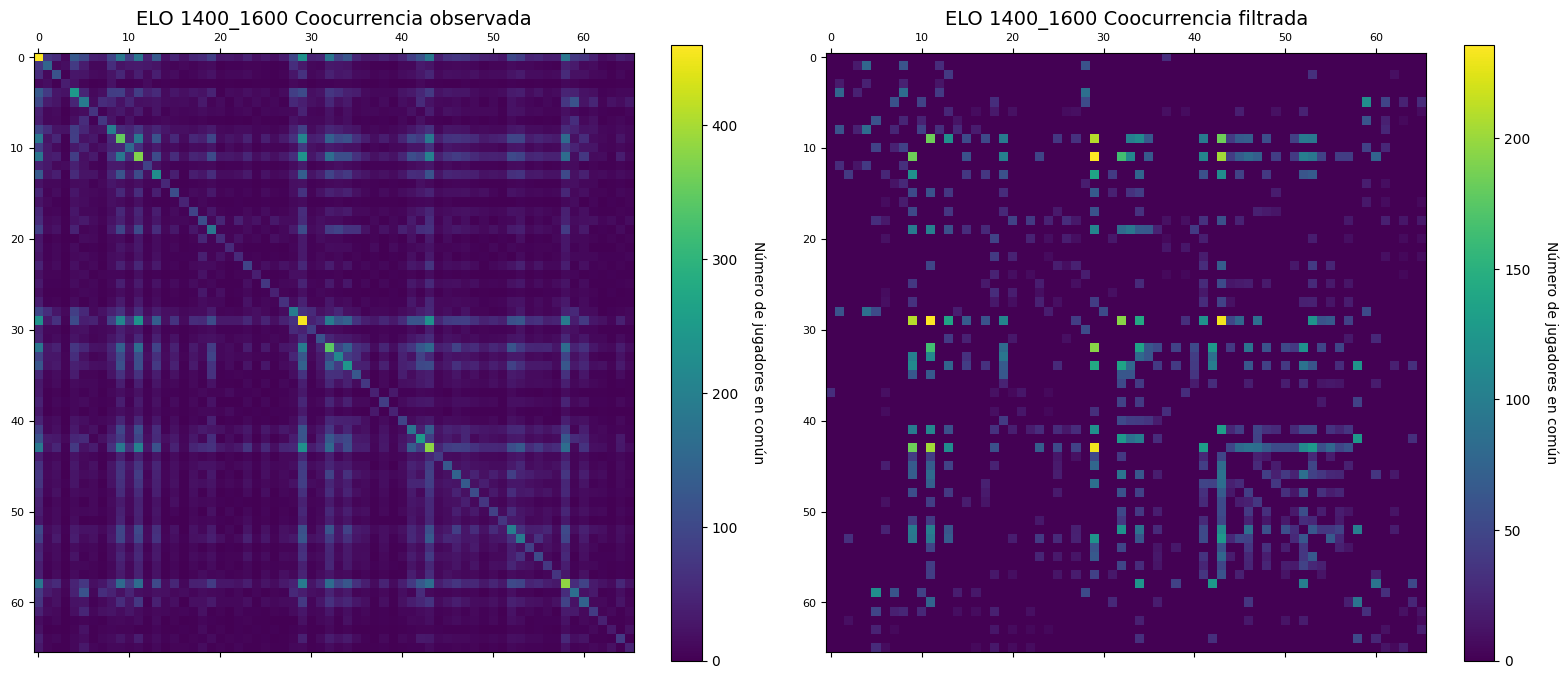

In [40]:
graficar_mapas_calor_coocurrencia(W_real_1400_1600, W_1400_1600, prefijo_titulo="ELO 1400_1600")


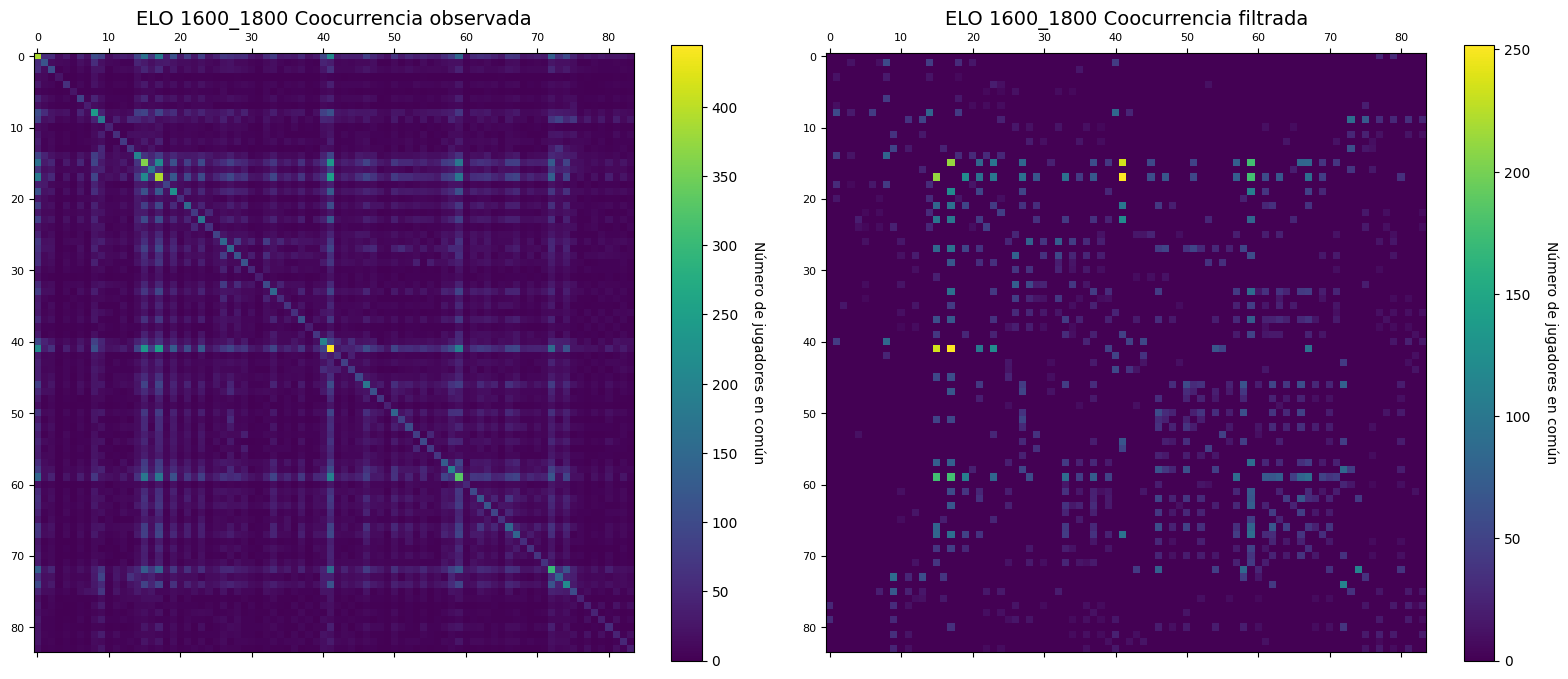

In [41]:
graficar_mapas_calor_coocurrencia(W_real_1600_1800, W_1600_1800, prefijo_titulo="ELO 1600_1800")

# Primer vista del grafo

In [42]:
def analizar_grafo(W_filtered, usar_pesos=True):

    Grafo = nx.from_numpy_array(W_filtered)
    info = {
        'es_multigrafo': Grafo.is_multigraph(),
        'es_dirigido': nx.is_directed(Grafo),
        'es_pesado': nx.is_weighted(Grafo),
        'es_conectado': nx.is_connected(Grafo)
    }
    print('Grafo observado:')
    print(Grafo)
    print('Es multigrafo?:', info['es_multigrafo'])
    print('Es dirigido?:', info['es_dirigido'])
    print('Es pesado?:', info['es_pesado'])
    print('Es conectado?:', info['es_conectado'])
    
    edges = Grafo.edges(data=True)
    if usar_pesos:
        # usando los pesos de la matriz de coocurrencia
        pesos = [d.get('weight', 1) for (u, v, d) in edges]
    else:
        # Ignorar los pesos
        pesos = [1 for (u, v, d) in edges]
    
    # Normalización de pesos para el grosor de las aristas
    if len(pesos) > 0:
        min_peso = min(pesos)
        max_peso = max(pesos)
        if max_peso > min_peso:
            widths = [1 + 4 * (p - min_peso) / (max_peso - min_peso) for p in pesos]
        else:
            widths = [2 for _ in pesos]
    else:
        widths = 1

    pos = nx.spring_layout(Grafo, seed=42)
    fig, ax = plt.subplots(figsize=(8, 6))
    nx.draw(
        Grafo, 
        pos=pos, 
        labels={i: i for i in Grafo.nodes}, 
        with_labels=True, 
        width=widths, 
        edge_color=pesos, 
        edge_cmap=plt.cm.Blues if usar_pesos else None, 
        node_color="#A0CBE2",
        ax=ax
    )
    if usar_pesos and len(pesos) > 0 and max(pesos) > min(pesos):
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(pesos), vmax=max(pesos)))
        sm.set_array([])
        plt.colorbar(sm, label="Peso de la arista", ax=ax)
    plt.show()

Grafo observado:
Graph with 52 nodes and 223 edges
Es multigrafo?: False
Es dirigido?: False
Es pesado?: True
Es conectado?: False


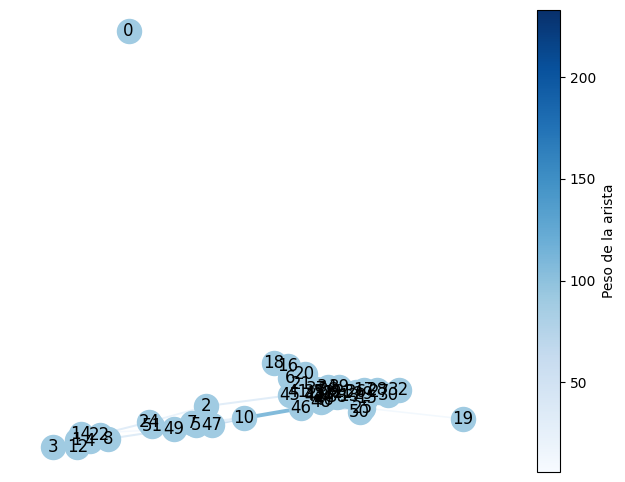

In [43]:
analizar_grafo(W_1200_1400)

Grafo observado:
Graph with 66 nodes and 335 edges
Es multigrafo?: False
Es dirigido?: False
Es pesado?: True
Es conectado?: True


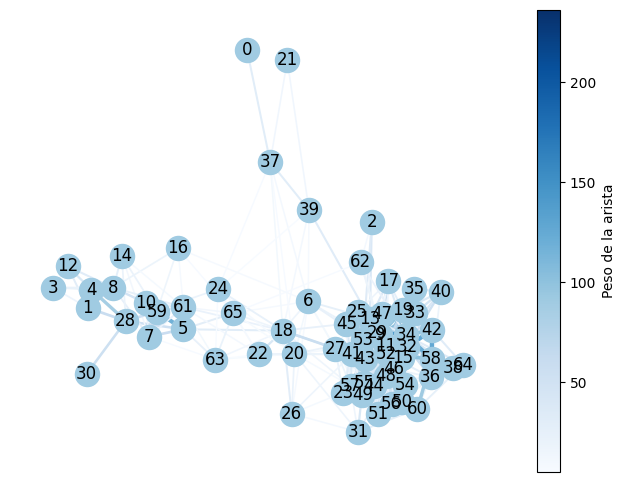

In [44]:
analizar_grafo(W_1400_1600)

Grafo observado:
Graph with 84 nodes and 391 edges
Es multigrafo?: False
Es dirigido?: False
Es pesado?: True
Es conectado?: True


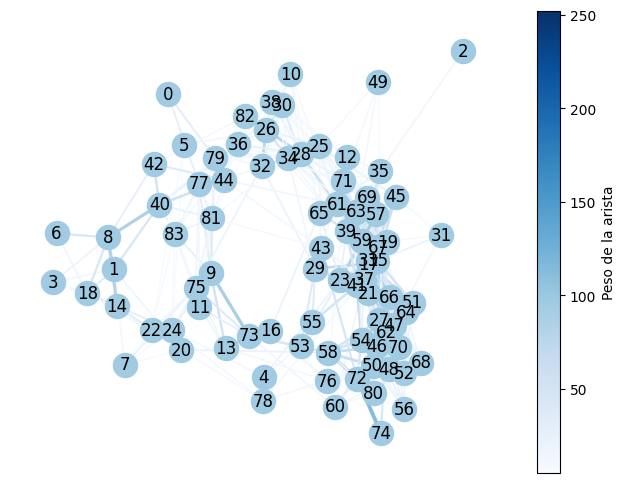

In [45]:
analizar_grafo(W_1600_1800)

## Obtengo la componente conectada de cada red con la cual voy a trabajar. 

In [46]:
def obtener_mapeo_aperturas(df):
    aperturas = list(df.columns)
    nodo_a_apertura = {i: apertura for i, apertura in enumerate(aperturas)}
    return aperturas, nodo_a_apertura

aperturas_1200_1400,nodo_a_apertura_1200_1400=obtener_mapeo_aperturas(matriz_bipartita_1200_1400)
aperturas_1400_1600,nodo_a_apertura_1400_1600=obtener_mapeo_aperturas(matriz_bipartita_1400_1600)
aperturas_1600_1800,nodo_a_apertura_1600_1800=obtener_mapeo_aperturas(matriz_bipartita_1600_1800)


In [47]:
def grafo_componente_principal(W_filtered, aperturas):

    W_df = pd.DataFrame(W_filtered, index=aperturas, columns=aperturas)
    # Crea el grafo usando los nombres de las aperturas como nodos
    G = nx.from_pandas_adjacency(W_df)
    # Encuentra todas las componentes conexas
    componentes = list(nx.connected_components(G))
    # Selecciona la componente más grande
    mayor_componente = max(componentes, key=len)
    # Crea el subgrafo correspondiente a la componente principal
    G_mayor = G.subgraph(mayor_componente).copy()
    # Lista de nombres de nodos en la componente principal
    nombres_componentes_principales = list(G_mayor.nodes)
    print(f"Número de nodos en la componente principal: {len(nombres_componentes_principales)}")    
    return G_mayor, nombres_componentes_principales

## Grafo pesado


In [48]:
G_mayor_1200_1400, nombres_componentes_principales_1200_1400 = grafo_componente_principal(W_1200_1400, aperturas_1200_1400)

Número de nodos en la componente principal: 51


In [49]:
G_mayor_1400_1600, nombres_componentes_principales_1400_1600 = grafo_componente_principal(W_1400_1600, aperturas_1400_1600)

Número de nodos en la componente principal: 66


In [50]:
G_mayor_1600_1800, nombres_componentes_principales_1600_1800 = grafo_componente_principal(W_1600_1800, aperturas_1600_1800)

Número de nodos en la componente principal: 84


# Plot grafos componente gigante

In [53]:
def grafo(G,
        dibujar=True,
        k_layout=0.15,
        seed=42,
        titulo="Grafo de coocurrencia"):
    
    # 2) Estadísticas rápidas
    info = {
        'N_nodos': G.number_of_nodes(),
        'N_aristas': G.number_of_edges(),
        'grado_medio': np.mean([d for _, d in G.degree()]),
        'peso_promedio': np.mean([d.get('weight',1) for *_,d in G.edges(data=True)])
    }

    # Impresión breve
    print("→ N nodos:      ", info['N_nodos'])
    print("→ N aristas:    ", info['N_aristas'])
    print("→ Grado medio:  ", f"{info['grado_medio']:.2f}")
    print("→ Peso medio:   ", f"{info['peso_promedio']:.2f}")

    if dibujar and info['N_nodos'] > 0:
        pos = nx.spring_layout(G, k=k_layout, seed=seed)

        node_colors = "#A0CBE2"

        grados = dict(G.degree())
        sizes = [50 + 200*(grados[n]/max(grados.values())) for n in G.nodes()]

        raw_weights = np.array([d.get('weight',1) for *_,d in G.edges(data=True)])
        w2 = raw_weights
        
        mi, ma = w2.min(), w2.max()
        widths = 1 + 2*(w2 - mi)/(ma - mi) if ma > mi else np.full_like(w2,2.0)
        alphas = 0.5 + 0.5*(w2 - mi)/(ma - mi)

        fig, ax = plt.subplots(figsize=(9,7))
        
        nx.draw_networkx_edges(
            G, pos,
            width=widths,
            alpha=alphas,
            edge_color=raw_weights,
            edge_cmap=plt.cm.Blues,
            ax=ax
        )
        
        nx.draw_networkx_nodes(
            G, pos,
            node_size=sizes,
            node_color=node_colors,
            ax=ax
        )
        
        nx.draw_networkx_labels(
            G, pos,
            font_size=8,
            font_color='black',
            ax=ax
        )
        
        ax.set_axis_off()
        plt.title(titulo, fontsize=14)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues,
                                   norm=plt.Normalize(vmin=raw_weights.min(),
                                                      vmax=raw_weights.max()))
        sm.set_array([])
        plt.colorbar(sm, label="Peso de arista", ax=ax)
        plt.show()

→ N nodos:       51
→ N aristas:     223
→ Grado medio:   8.75
→ Peso medio:    62.33


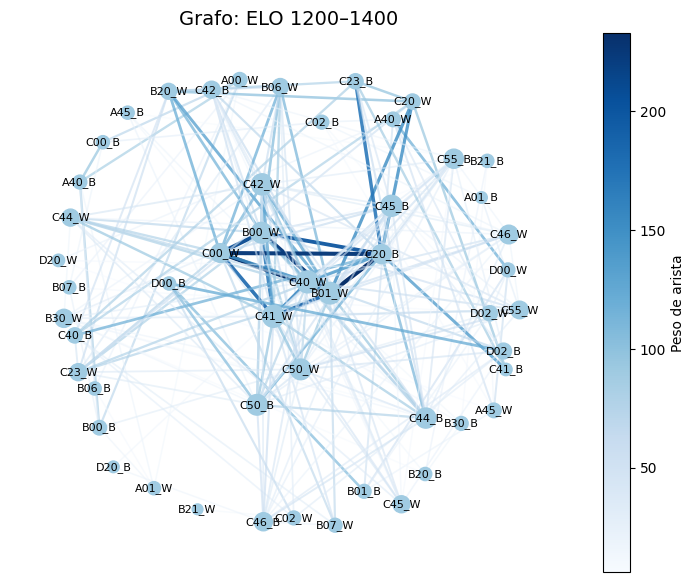

In [54]:
grafo(G_mayor_1200_1400,
    dibujar=True,
    k_layout=8,
    seed=42,
    titulo="Grafo: ELO 1200–1400")

→ N nodos:       66
→ N aristas:     335
→ Grado medio:   10.15
→ Peso medio:    45.93


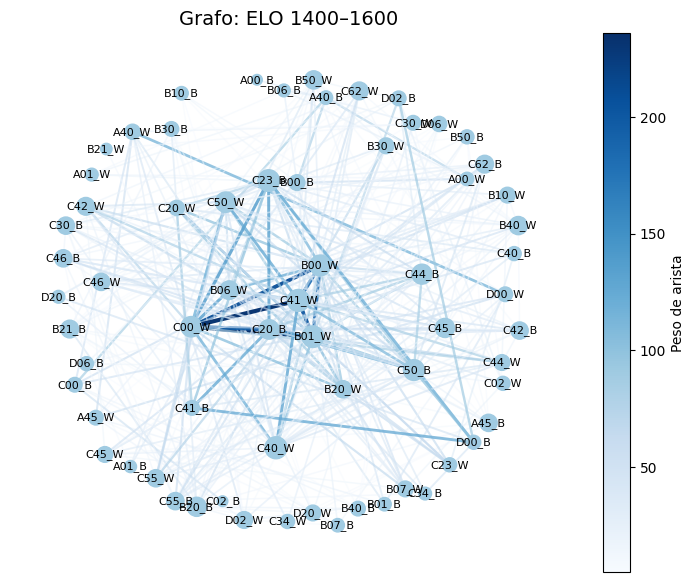

In [55]:
grafo(G_mayor_1400_1600,
    dibujar=True,
    k_layout=8,
    seed=42,
    titulo="Grafo: ELO 1400–1600")

→ N nodos:       84
→ N aristas:     391
→ Grado medio:   9.31
→ Peso medio:    33.60


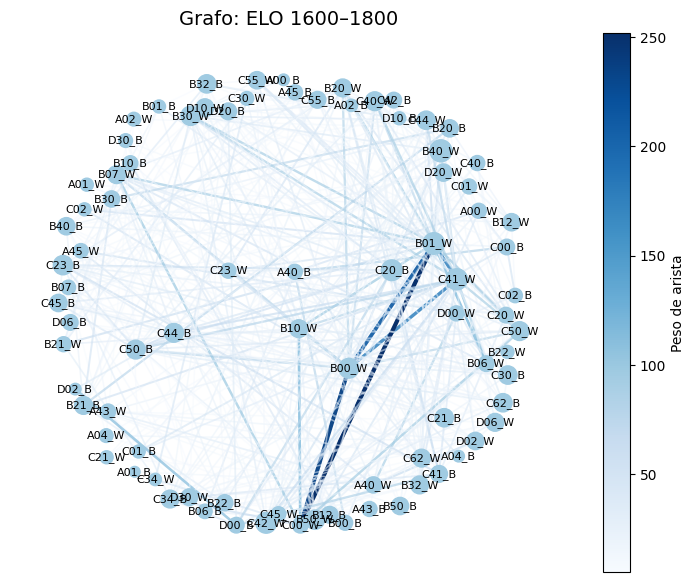

In [56]:
grafo(G_mayor_1600_1800,
    dibujar=True,
    k_layout=8,
    seed=42,
    titulo="Grafo: ELO 1600–1800")

## Topologia de la red. 



In [58]:
def plot_dist_nodos_pesos(graphs,
                          labels=None,
                          bins=30,
                          figsize_per_graph=(8, 4)):
    if labels is None:
        labels = [f"Grafo {i+1}" for i in range(len(graphs))]
    n = len(graphs)
    fig, axes = plt.subplots(n, 2,
                             figsize=(figsize_per_graph[0],
                                      figsize_per_graph[1] * n),
                             sharex=False)
    if n == 1:
        axes = np.array([axes])
    
    for i, (G, label) in enumerate(zip(graphs, labels)):
        ax_deg, ax_wt = axes[i]

        grados = [d for _, d in G.degree()]
        if grados:
            vals, counts = np.unique(grados, return_counts=True)
            ax_deg.bar(vals, counts, alpha=0.8, width=0.8)
        ax_deg.set_title(f"{label} — Grados")
        ax_deg.set_xlabel("Grado")
        ax_deg.set_ylabel("# Nodos")
        ax_deg.grid(alpha=0.3)

        
        pesos = [data.get('weight', 1) for u, v, data in G.edges(data=True)]
        ax_wt.set_title(f"{label} — Pesos de enlaces")
        if not pesos:
            ax_wt.text(0.5, 0.5, "(sin pesos)", ha='center', va='center')
        else:
            ax_wt.hist(pesos, bins=bins, density=True, alpha=0.6)
            ax_wt.set_xlabel("Peso")
            ax_wt.set_ylabel("Proporción")
        ax_wt.grid(alpha=0.3)

    fig.suptitle("Propiedades de la red: grados y pesos de enlaces", fontsize=16)
    fig.canvas.draw() 
    fig_width, fig_height = fig.get_size_inches()
    fig_line_y = 0.95  
    fig_line = plt.Line2D([0.05, 0.95], [fig_line_y, fig_line_y], color='black', linewidth=1, transform=fig.transFigure, clip_on=False)
    fig.add_artist(fig_line)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


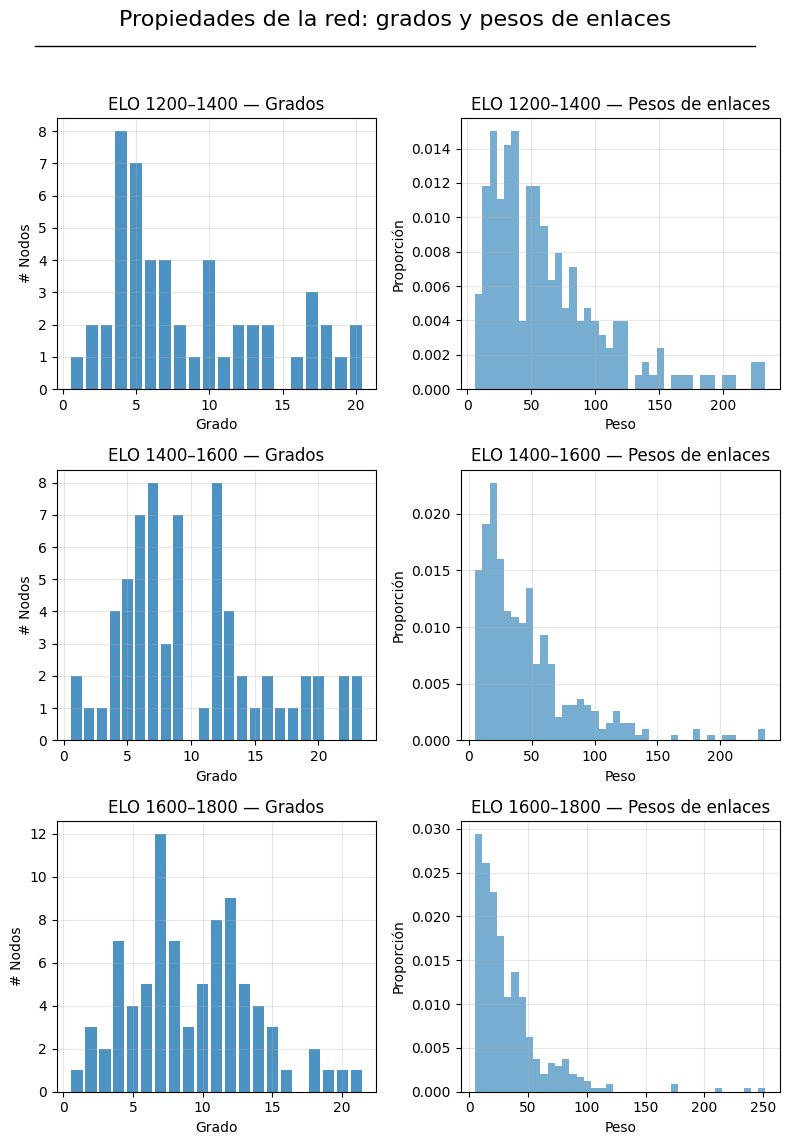

In [59]:
plot_dist_nodos_pesos(
    graphs=[G_mayor_1200_1400, G_mayor_1400_1600, G_mayor_1600_1800],
    labels=["ELO 1200–1400", "ELO 1400–1600", "ELO 1600–1800"],
    bins=40
)

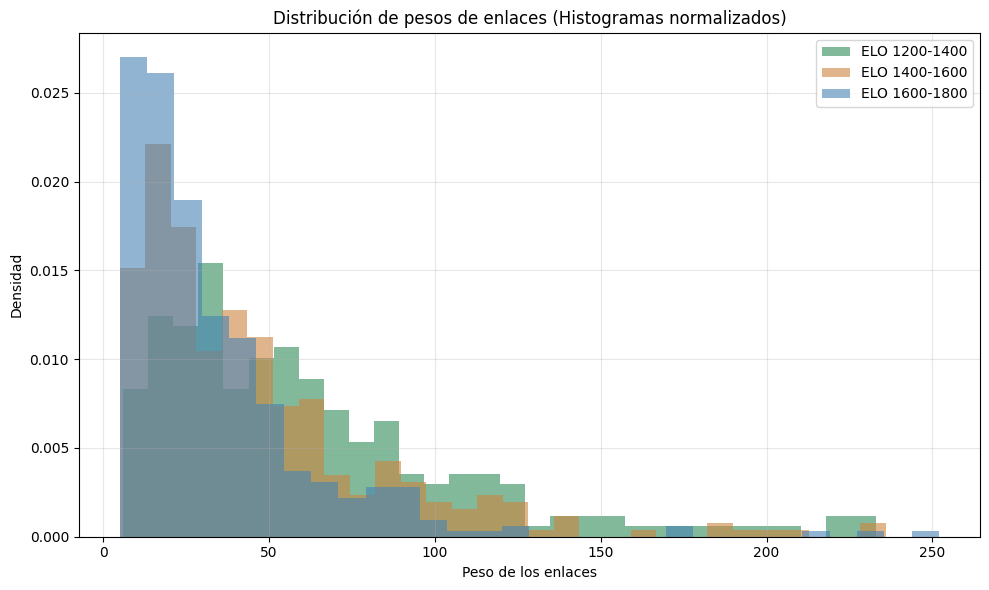

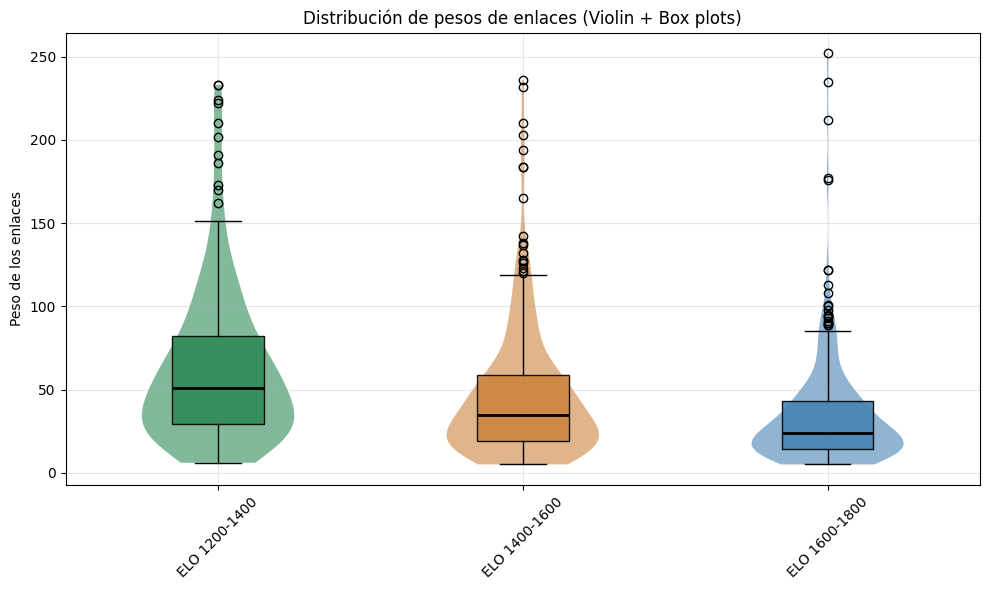

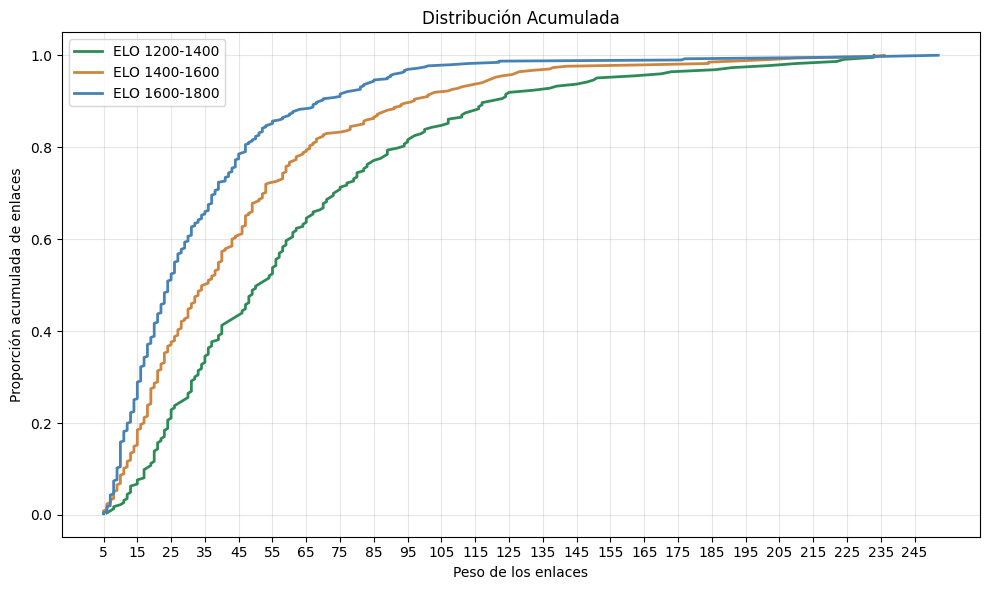

In [60]:
def plot_distribucion_pesos(graphs, labels=None, plot_type='histogram'):
    
    if labels is None:
        labels = [f"Grafo {i+1}" for i in range(len(graphs))]
    
    # Extraer pesos de cada grafo
    weights_data = []
    for G in graphs:
        weights = [data['weight'] for u, v, data in G.edges(data=True) if 'weight' in data]
        weights_data.append(weights)
    
    if plot_type == 'histogram':
        plt.figure(figsize=(10, 6))
        colors = ['#2E8B57', '#CD853F', '#4682B4', '#DC143C', '#9370DB', '#FF8C00']
        
        for i, (weights, label) in enumerate(zip(weights_data, labels)):
            if len(weights) > 0:
                # Histograma normalizado (densidad)
                plt.hist(weights, bins=30, alpha=0.6, label=label, 
                        color=colors[i % len(colors)], density=True)
        
        plt.xlabel('Peso de los enlaces')
        plt.ylabel('Densidad')
        plt.title('Distribución de pesos de enlaces (Histogramas normalizados)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    
    elif plot_type == 'boxplot_violin':
        plt.figure(figsize=(10, 6))
        
        # Preparar datos para boxplot y violin
        data_for_plot = []
        labels_for_plot = []
        
        for weights, label in zip(weights_data, labels):
            if len(weights) > 0:
                data_for_plot.append(weights)
                labels_for_plot.append(label)
        
        positions = range(1, len(data_for_plot)+1)
        
        # Crear violin plot
        parts = plt.violinplot(data_for_plot, positions=positions, showmeans=False, 
                              showmedians=False, showextrema=False)
        
        # Personalizar colores del violin
        colors = ['#2E8B57', '#CD853F', '#4682B4', '#DC143C', '#9370DB', '#FF8C00']
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i % len(colors)])
            pc.set_alpha(0.6)
        
        # Superponer boxplot
        box_parts = plt.boxplot(data_for_plot, positions=positions, widths=0.3,
                               patch_artist=True, boxprops=dict(facecolor='white', alpha=0.8),
                               medianprops=dict(color='black', linewidth=2))
        
        # Colorear las cajas del boxplot
        for i, patch in enumerate(box_parts['boxes']):
            patch.set_facecolor(colors[i % len(colors)])
            patch.set_alpha(0.9)
        
        plt.xticks(positions, labels_for_plot, rotation=45)
        plt.ylabel('Peso de los enlaces')
        plt.title('Distribución de pesos de enlaces (Violin + Box plots)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    elif plot_type == 'ecdf':
        plt.figure(figsize=(10, 6))
        colors = ['#2E8B57', '#CD853F', '#4682B4', '#DC143C', '#9370DB', '#FF8C00']
        
        min_x = None
        max_x = None

        for i, (weights, label) in enumerate(zip(weights_data, labels)):
            if len(weights) > 0:
                weights_sorted = np.sort(weights)
                n = len(weights_sorted)
                ecdf_y = np.arange(1, n+1) / n

                # Guardar min y max para los ticks
                if min_x is None or weights_sorted[0] < min_x:
                    min_x = weights_sorted[0]
                if max_x is None or weights_sorted[-1] > max_x:
                    max_x = weights_sorted[-1]
                
                plt.plot(weights_sorted, ecdf_y, label=label, 
                        color=colors[i % len(colors)], linewidth=2)
        
        plt.xlabel('Peso de los enlaces')
        plt.ylabel('Proporción acumulada de enlaces')
        plt.title('Distribución Acumulada')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Agregar etiquetas al eje x de 10 en 10
        if min_x is not None and max_x is not None:
            # Si los pesos son enteros y el rango es grande, usar ticks de 10 en 10
            try:
                min_tick = int(np.floor(min_x))
                max_tick = int(np.ceil(max_x))
                if max_tick - min_tick > 10:
                    ticks = np.arange(min_tick, max_tick+1, 10)
                    plt.xticks(ticks)
            except Exception:
                pass  # Si no son números, no forzar los ticks

        plt.tight_layout()
        plt.show()
    elif plot_type == 'rank_order':
        plt.figure(figsize=(10, 6))
        colors = ['#2E8B57', '#CD853F', '#4682B4', '#DC143C', '#9370DB', '#FF8C00']
        
        for i, (weights, label) in enumerate(zip(weights_data, labels)):
            if len(weights) > 0:
                weights_sorted = np.sort(weights)[::-1]  
                ranks = np.arange(1, len(weights_sorted)+1)
                
                plt.loglog(ranks, weights_sorted, 'o-', label=label, 
                          color=colors[i % len(colors)], alpha=0.7, markersize=3)
        
        plt.xlabel('Rango k')
        plt.ylabel('Peso w(k)')
        plt.title('Rank-Order Plot (escala log-log)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    else:
        print(f"Tipo de gráfico '{plot_type}' no reconocido.")
        print("Opciones disponibles: 'histogram', 'boxplot', 'violin', 'boxplot_violin', 'ecdf', 'rank_order'")


graphs_elo = [G_mayor_1200_1400, G_mayor_1400_1600, G_mayor_1600_1800]
labels_elo = ["ELO 1200-1400", "ELO 1400-1600", "ELO 1600-1800"]

#Histograma
plot_distribucion_pesos(graphs_elo, labels_elo, 'histogram')
# boxplot_violin
plot_distribucion_pesos(graphs_elo, labels_elo, 'boxplot_violin')
# ECDF
plot_distribucion_pesos(graphs_elo, labels_elo, 'ecdf')

Interpretación de tus redes ELO
Bajo ELO

Pocos enlaces, pero con pesos relativamente altos: esto indica que la mayoría de los jugadores juegan aperturas muy convencionales (pocos pares distintos de aperturas) y repiten mucho esas mismas combinaciones.

La red se ve menos densa y con comunidades muy marcadas alrededor de los “tours” principales (e4 e5, d4 d5, etc.).

Medio ELO

Hay más enlaces distintos (se exploran más pares de aperturas), pero los pesos medios bajan, porque las aperturas secundarias se usan con menor frecuencia.

El clustering local empieza a desdibujarse: aparecen más “puentes” entre grupos de aperturas.

Alto ELO

La red es más densa aún, con muchos enlaces de peso bajo: los maestros prueban más líneas nuevas y raras, pero cada una las juegan pocas veces.

La modularidad global baja levemente: muchas aperturas “marginales” conectan distintas comunidades antes muy separadas.

En conjunto, la evolución de tu red muestra un paso de la rigidez (“solo lo seguro”) a la exploración táctica a medida que sube el nivel de ELO. Esto coincide con tu intuición: los jugadores fuertes introducen más variaciones, lo que se traduce en muchas aristas de bajo peso—justo lo que tu nueva función de dibujo resaltará con aristas finas y pálidas

## Metricas

## Para las metricas tener en cuenta los pesos

In [61]:
def metricas_ponderadas(G, verbose=False):
    resultados = {}

    # Número de nodos y aristas (no se normalizan)
    n_nodos = G.number_of_nodes()
    n_aristas = G.number_of_edges()
    resultados['n_nodos'] = n_nodos
    resultados['n_aristas'] = n_aristas

    # 1. Densidad ponderada
    # Dw = (1 / (N(N-1))) * suma de todos los pesos normalizados
    peso_total = sum([edata['weight'] for _,_,edata in G.edges(data=True)])
    peso_max = max([edata['weight'] for _,_,edata in G.edges(data=True)])
    
    # Normalizar pesos dividiendo por el peso máximo
    suma_pesos_normalizados = sum([edata['weight']/peso_max for _,_,edata in G.edges(data=True)])
    densidad_ponderada = suma_pesos_normalizados / (n_nodos * (n_nodos - 1))
    resultados['densidad_ponderada'] = densidad_ponderada

    # 2. Coeficiente de clustering ponderado (promedio)
    # Usa la implementación de NetworkX que sigue el método de Barrat et al.
    clustering_ponderado = nx.average_clustering(G, weight='weight')
    resultados['clustering_ponderado'] = clustering_ponderado

    # 3. Modularidad ponderada usando detección de comunidades Louvain
    try:
        # Detectar comunidades usando Louvain con pesos
        import networkx.algorithms.community as nx_comm
        comunidades = nx_comm.louvain_communities(G, weight='weight')
        
        # Calcular modularidad ponderada
        modularidad_ponderada = nx_comm.modularity(G, comunidades, weight='weight')
        resultados['modularidad_ponderada'] = modularidad_ponderada
    except:
        # Si hay algún error con la detección de comunidades
        resultados['modularidad_ponderada'] = 0.0

    # 4. Transitividad ponderada
    # Usa la implementación de NetworkX para transitividad con pesos
    transitividad_ponderada = nx.transitivity(G)  # NetworkX no tiene versión ponderada directa
    # Calculamos una versión manual considerando pesos en triángulos
    triangulos_ponderados = 0
    tripletas_ponderadas = 0
    
    for nodo in G.nodes():
        vecinos = list(G.neighbors(nodo))
        if len(vecinos) >= 2:
            for i in range(len(vecinos)):
                for j in range(i+1, len(vecinos)):
                    v1, v2 = vecinos[i], vecinos[j]
                    peso_nodo_v1 = G[nodo][v1]['weight']
                    peso_nodo_v2 = G[nodo][v2]['weight']
                    
                    # Contar tripleta ponderada
                    tripletas_ponderadas += (peso_nodo_v1 + peso_nodo_v2) / 2
                    
                    # Si existe arista entre v1 y v2, es un triángulo ponderado
                    if G.has_edge(v1, v2):
                        peso_v1_v2 = G[v1][v2]['weight']
                        triangulos_ponderados += (peso_nodo_v1 + peso_nodo_v2 + peso_v1_v2) / 3
    
    if tripletas_ponderadas > 0:
        transitividad_ponderada = triangulos_ponderados / tripletas_ponderadas
    else:
        transitividad_ponderada = 0.0
    
    resultados['transitividad_ponderada'] = transitividad_ponderada

    # 5. Asortatividad ponderada
    asortatividad_ponderada = nx.degree_assortativity_coefficient(G, weight='weight')
    resultados['asortatividad_ponderada'] = asortatividad_ponderada

    if verbose:
        print("----- Medidas topológicas ponderadas -----")
        print(f"Número de nodos: {resultados['n_nodos']}")
        print(f"Número de aristas: {resultados['n_aristas']}")
        print(f"Densidad ponderada: {resultados['densidad_ponderada']:.6f}")
        print(f"Clustering ponderado: {resultados['clustering_ponderado']:.6f}")
        print(f"Modularidad ponderada: {resultados['modularidad_ponderada']:.6f}")
        print(f"Transitividad ponderada: {resultados['transitividad_ponderada']:.6f}")
        print(f"Asortatividad ponderada: {resultados['asortatividad_ponderada']:.6f}")

    # Convertir el diccionario a DataFrame
    df_resultados = pd.DataFrame(list(resultados.items()), columns=['metrica', 'valor_normalizado'])
    return df_resultados

In [62]:
metricas_1200_1400_ponderadas = metricas_ponderadas(G_mayor_1200_1400)

In [63]:
metricas_1400_1600_ponderadas= metricas_ponderadas(G_mayor_1400_1600)

In [64]:
metricas_1600_1800_ponderadas=metricas_ponderadas(G_mayor_1600_1800)

In [65]:
metricas_1600_1800_ponderadas

,metrica,valor_normalizado
0,n_nodos,84.000000
1,n_aristas,391.000000
2,densidad_ponderada,0.007478
3,clustering_ponderado,0.054263
4,modularidad_ponderada,0.485390
5,transitividad_ponderada,0.463859
6,asortatividad_ponderada,0.260924


In [66]:
# Renombrar la columna 'valores' en cada DataFrame antes de concatenar
df_1200_1400_metricas_ponderadas = metricas_1200_1400_ponderadas.rename(columns={'valor_normalizado': 'ELO 1200-1400'})
df_1400_1600_metricas_ponderadas = metricas_1400_1600_ponderadas.rename(columns={'valor_normalizado': 'ELO 1400-1600'})
df_1600_1800_metricas_ponderadas = metricas_1600_1800_ponderadas.rename(columns={'valor_normalizado': 'ELO 1600-1800'})

# Unir por la columna 'metricas'
metricas_totales = df_1200_1400_metricas_ponderadas[['metrica', 'ELO 1200-1400']].merge(
    df_1400_1600_metricas_ponderadas[['metrica', 'ELO 1400-1600']], on='metrica'
).merge(
    df_1600_1800_metricas_ponderadas[['metrica', 'ELO 1600-1800']], on='metrica'
)

metricas_totales

,metrica,ELO 1200-1400,ELO 1400-1600,ELO 1600-1800
0,n_nodos,51.000000,66.000000,84.000000
1,n_aristas,223.000000,335.000000,391.000000
2,densidad_ponderada,0.023395,0.015199,0.007478
3,clustering_ponderado,0.136121,0.088696,0.054263
4,modularidad_ponderada,0.304780,0.338338,0.485390
5,transitividad_ponderada,0.607501,0.502561,0.463859
6,asortatividad_ponderada,0.228610,0.154250,0.260924


In [67]:
# Diccionario de reemplazo para los nombres de las métricas
reemplazos = {
    'n_nodos': 'Nodos',
    'n_aristas': 'Aristas',
    'densidad_ponderada': 'Densidad',
    'clustering_ponderado': 'Clustering',
    'modularidad_ponderada': 'Modularidad',
    'transitividad_ponderada': 'Transitividad',
    'asortatividad_ponderada': 'Asortatividad',
}

metricas_totales['metrica'] = metricas_totales['metrica'].replace(reemplazos)
metricas_totales

,metrica,ELO 1200-1400,ELO 1400-1600,ELO 1600-1800
0,Nodos,51.000000,66.000000,84.000000
1,Aristas,223.000000,335.000000,391.000000
2,Densidad,0.023395,0.015199,0.007478
3,Clustering,0.136121,0.088696,0.054263
4,Modularidad,0.304780,0.338338,0.485390
5,Transitividad,0.607501,0.502561,0.463859
6,Asortatividad,0.228610,0.154250,0.260924


🌐 3. densidad_ponderada
Qué mide: suma de pesos normalizada respecto al máximo posible (es decir, cuánto "peso" hay distribuido en la red).

Evolución:

Disminuye drásticamente de 0.023 a 0.0074.

Interpretación:

Aunque hay más nodos y más aristas, el peso promedio por conexión baja. O sea:

Se usan más aperturas, pero cada combinación de aperturas es menos compartida entre jugadores.

Hay más exploración, pero menos coincidencia entre individuos. Esto es típico en niveles altos donde cada jugador tiene su estilo.

🔺 4. clustering_ponderado
Qué mide: cuán probable es que si A se conecta fuerte con B y B con C, entonces A también se conecte con C con peso relevante.

Evolución:

Baja de 0.136 a 0.054.

Interpretación:

Las tripletas densas de aperturas (usadas juntas) son más comunes en niveles bajos.

En niveles altos, las aperturas no forman "grupos cerrados" de coocurrencia tan claramente definidos.

🧩 5. modularidad_ponderada
Qué mide: qué tan bien se puede particionar la red en comunidades con muchas conexiones internas y pocas externas.

Evolución:

Aumenta de 0.30 a 0.46.

Interpretación:

A mayor ELO, la red se vuelve más modular: aparecen grupos de aperturas más diferenciados que se coocurren principalmente entre sí.

Esto podría reflejar estilos de repertorio más definidos por jugador (por ejemplo, los que solo juegan aperturas cerradas vs. abiertas).

🔁 6. transitividad_ponderada
Qué mide: proporción global de triángulos con peso significativo (una forma más global del clustering).

Evolución:

Baja de 0.60 a 0.46.

Interpretación:

En niveles bajos hay más triángulos "fuertes", es decir, grupos cerrados de aperturas compartidas por muchos jugadores.

A medida que aumenta el ELO, estas conexiones “tripartitas” son más débiles o dispersas.

🧠 ¿Qué resalta?
La modularidad aumenta, mientras que la densidad y clustering bajan. Esto sugiere una transición desde un repertorio compartido por todos (ELO bajo) hacia repertorios más personalizados y especializados (ELO alto).

El comportamiento es coherente con un sistema que se vuelve más complejo y diversificado a medida que mejora el nivel de juego.

## Deteccion de comunidades

In [68]:
def detectar_comunidades(G):
    communities = list(community.greedy_modularity_communities(G))
    return communities

def graficar_comunidades(G, communities, elo_titulo=None):
    # Calcular modularidad ponderada de cada comunidad
    modularidades_ponderadas = []
    for comm in communities:
        subg = G.subgraph(comm)
        try:
            df_metricas = metricas_ponderadas(subg)
            modularidad_ponderada = df_metricas[df_metricas['metrica'] == 'modularidad_ponderada']['valor_normalizado'].values
            modularidad_ponderada = float(modularidad_ponderada[0]) if len(modularidad_ponderada) > 0 else None
        except Exception as e:
            modularidad_ponderada = None
        modularidades_ponderadas.append(modularidad_ponderada)

    # Color mapping
    node_color_map = {}
    color_list = list(mcolors.TABLEAU_COLORS) + list(mcolors.CSS4_COLORS)
    community_colors = {}
    
    for idx, comm in enumerate(communities):
        color = color_list[idx % len(color_list)]
        community_colors[idx] = color
        for node in comm:
            node_color_map[node] = color

    node_colors = [node_color_map.get(n, "#cccccc") for n in G.nodes()]
    
    # Color a cada nodo
    node_edgecolors = []
    for _ in G.nodes():
        node_edgecolors.append('gray')
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    
    # Plot nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, alpha=0.85,
                          edgecolors=node_edgecolors, linewidths=1)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    # Agregar etiquetas de nodos
    nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold', alpha=0.9)

    # Leyenda
    legend_elements = []
    for idx, comm in enumerate(communities):
        color = color_list[idx % len(color_list)]
        mod_pond = modularidades_ponderadas[idx]
        if mod_pond is not None:
            label = f'Comunidad {idx+1} (mod={mod_pond:.3f})'
        else:
            label = f'Comunidad {idx+1} (mod=N/A)'
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=color, markersize=10,
                                        label=label))

    plt.legend(handles=legend_elements, loc='upper left')

    title = f"Comunidades de Aperturas - ELO {elo_titulo}" if elo_titulo else "Comunidades de Aperturas"
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def calcular_metricas_grafo(G, communities):
    # Calcula la modularidad global
    mod = modularity(G, communities)
    
    # Información por comunidad
    comunidades_info = []
    for i, comm in enumerate(communities[:5]):
        subg = G.subgraph(comm)
        # Calcular modularidad ponderada de la subcomunidad
        try:
            df_metricas = metricas_ponderadas(subg)
            modularidad_ponderada = df_metricas[df_metricas['metrica'] == 'modularidad_ponderada']['valor_normalizado'].values
            modularidad_ponderada = float(modularidad_ponderada[0]) if len(modularidad_ponderada) > 0 else None
        except Exception as e:
            modularidad_ponderada = None
        comunidades_info.append({
            'familia': i+1,
            'tamaño': len(comm),
            'miembros': list(comm)[:10],
            'cohesion': nx.density(subg),
            'modularidad_ponderada': modularidad_ponderada
        })
    
    return {
        'modularidad': mod,
        'comunidades': comunidades_info
    }

def metricas_dentro_comunidades(G, communities):
    
    comunidad_metricas = {}
    
    top_n = len(communities)
    
    # Ordenar comunidades por tamaño descendente
    comunidades_ordenadas = sorted(communities, key=len, reverse=True)[:top_n]
    
    # Diccionario para almacenar las métricas de todas las comunidades
    todas_metricas = {}
    
    for i, comunidad in enumerate(comunidades_ordenadas):
        subg = G.subgraph(comunidad).copy()
        
        try:
            df_m = metricas_ponderadas(subg)
            comunidad_metricas[f'omunidad_{i+1}'] = {
                'tamaño': len(subg),
                'nodos': list(subg.nodes)[:10],
                'metricas': df_m
            }
            
            # Agregar métricas al diccionario consolidado
            for _, row in df_m.iterrows():
                metrica = row['metrica']
                valor = row['valor_normalizado']
                if metrica not in todas_metricas:
                    todas_metricas[metrica] = {}
                todas_metricas[metrica][f'Comunidad {i+1}'] = valor
            

            print(f"\n>>> Comunidad {i+1} (n={len(subg)}):")
            print(f"Nodos principales: {list(subg.nodes)[:5]}")
                
        except Exception as e:
            print(f"Error analizando comunidad {i+1}: {e}")
    
    # Crear tabla consolidada
    if todas_metricas:
        df_consolidado = pd.DataFrame(todas_metricas).T
        df_consolidado = df_consolidado.fillna(0)  # Rellenar valores faltantes con 0
        
        print(f"\n=== TABLA CONSOLIDADA DE MÉTRICAS POR COMUNIDAD ===")
        print(df_consolidado.round(4))
        
        return comunidad_metricas, df_consolidado
    
    return comunidad_metricas, None

def analizar_coocurrencia_relevante(G, elo_titulo):

    print(f"=== ANÁLISIS DE COOCURRENCIA - ELO {elo_titulo} ===")
    
    # 1. Detectar comunidades
    communities = detectar_comunidades(G)
    
    # 2. Crear diccionario de comunidades
    diccionario_comunidades = {}
    for i, comm in enumerate(communities):
        diccionario_comunidades[f'Comunidad {i+1}'] = list(comm)
    
    # 3. Calcular métricas
    metricas = calcular_metricas_grafo(G, communities)
    
    # 4. Mostrar resultados
    print(f"\n=== FAMILIAS DE APERTURAS ===")
    print(f"Modularidad global: {metricas['modularidad']:.3f}")
    print(f"Número total de comunidades: {len(communities)}")
    

    print("\n--- Modularidad de cada comunidad ---")
    for info in metricas['comunidades']:
        print(f"\nFamilia {info.get('familia', 'N/A')}:")
        print(f"  Tamaño: {info.get('tamaño', 'N/A')}")
        print(f"  Miembros: {info.get('miembros', 'N/A')}...")
        print(f"  Cohesión: {info.get('cohesion', 'N/A'):.3f}" if 'cohesion' in info else "  Cohesión: N/A")
        # Mostrar la modularidad ponderada de la comunidad si existe
        if 'modularidad_ponderada' in info and info['modularidad_ponderada'] is not None:
            print(f"  Modularidad (ponderada): {info['modularidad_ponderada']:.3f}")
        elif 'modularidad' in info:
            print(f"  Modularidad: {info['modularidad']:.3f}")
        else:
            print("  Modularidad: N/A")
    
    # 5. Graficar comunidades
    graficar_comunidades(G, communities, elo_titulo)

    # 6. Analizar métricas por comunidad
    print(f"\n=== MÉTRICAS DE CADA COMUNIDAD ===")
    tabla_consolidada = metricas_dentro_comunidades(G, communities)
    
    return tabla_consolidada, diccionario_comunidades

=== ANÁLISIS DE COOCURRENCIA - ELO 1200-1400 ===

=== FAMILIAS DE APERTURAS ===
Modularidad global: 0.302
Número total de comunidades: 4

--- Modularidad de cada comunidad ---

Familia 1:
  Tamaño: 22
  Miembros: ['D02_B', 'C50_B', 'C44_B', 'C55_W', 'C45_B', 'C50_W', 'C55_B', 'C42_B', 'D20_B', 'B30_W']...
  Cohesión: 0.476
  Modularidad (ponderada): 0.086

Familia 2:
  Tamaño: 11
  Miembros: ['C40_B', 'B07_W', 'C23_W', 'B06_W', 'C20_B', 'C41_B', 'C23_B', 'C00_W', 'B20_W', 'C20_W']...
  Cohesión: 0.564
  Modularidad (ponderada): 0.173

Familia 3:
  Tamaño: 11
  Miembros: ['D02_W', 'D20_W', 'C02_W', 'D00_B', 'B01_B', 'A40_W', 'D00_W', 'B21_W', 'C02_B', 'A01_B']...
  Cohesión: 0.364
  Modularidad (ponderada): 0.251

Familia 4:
  Tamaño: 7
  Miembros: ['A01_W', 'B00_B', 'A00_W', 'B06_B', 'C00_B', 'B07_B', 'A40_B']...
  Cohesión: 0.714
  Modularidad (ponderada): 0.000


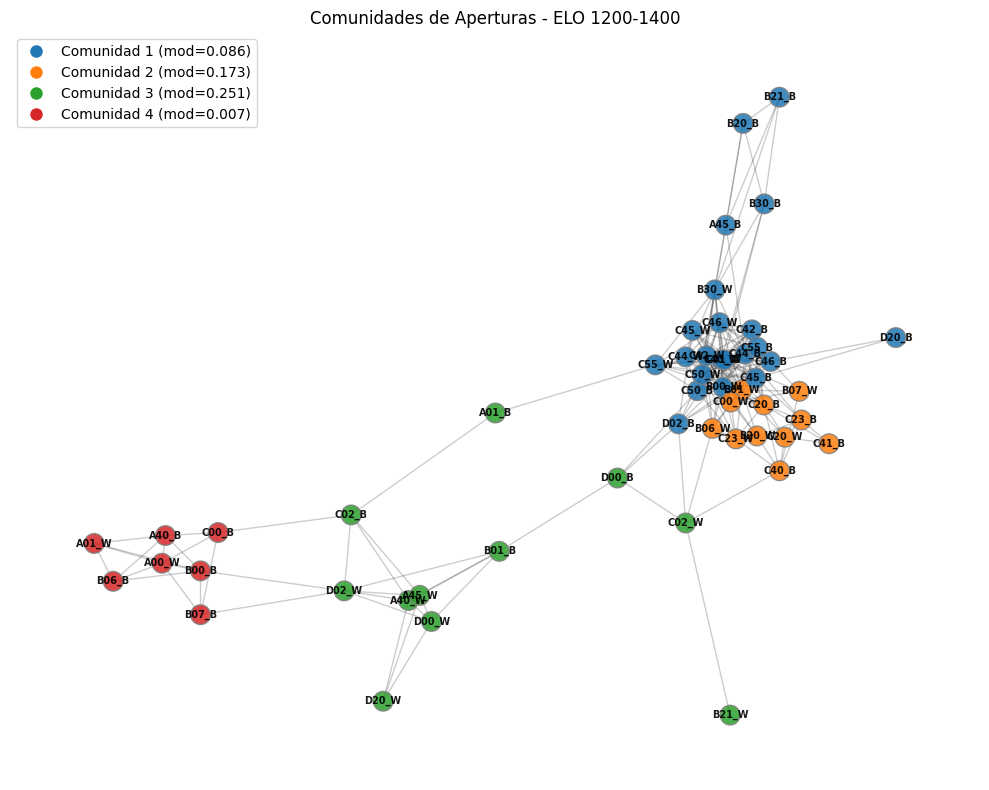


=== MÉTRICAS DE CADA COMUNIDAD ===

>>> Comunidad 1 (n=22):
Nodos principales: ['D02_B', 'C45_B', 'C55_B', 'D20_B', 'C46_B']

>>> Comunidad 2 (n=11):
Nodos principales: ['C40_B', 'B07_W', 'C23_W', 'B06_W', 'C20_B']

>>> Comunidad 3 (n=11):
Nodos principales: ['D02_W', 'D20_W', 'C02_W', 'D00_B', 'B01_B']

>>> Comunidad 4 (n=7):
Nodos principales: ['C00_B', 'B07_B', 'A40_B', 'A01_W', 'B00_B']

=== TABLA CONSOLIDADA DE MÉTRICAS POR COMUNIDAD ===
                         Comunidad 1  Comunidad 2  Comunidad 3  Comunidad 4
n_nodos                      22.0000      11.0000      11.0000       7.0000
n_aristas                   110.0000      31.0000      20.0000      15.0000
densidad_ponderada            0.0655       0.1271       0.0609       0.1577
clustering_ponderado          0.1820       0.2875       0.1321       0.3018
modularidad_ponderada         0.0863       0.1732       0.2515       0.0000
transitividad_ponderada       0.7598       0.6176       0.6941       0.7150
asortatividad_ponder

In [69]:
tabla_consolidada_1200_1400, dicc_comunidades_1200_1400= analizar_coocurrencia_relevante(G_mayor_1200_1400, '1200-1400')


=== ANÁLISIS DE COOCURRENCIA - ELO 1400-1600 ===

=== FAMILIAS DE APERTURAS ===
Modularidad global: 0.308
Número total de comunidades: 3

--- Modularidad de cada comunidad ---

Familia 1:
  Tamaño: 26
  Miembros: ['C30_W', 'C00_B', 'C34_W', 'B50_B', 'A00_B', 'D20_W', 'A00_W', 'B06_B', 'B00_B', 'A40_W']...
  Cohesión: 0.240
  Modularidad (ponderada): 0.448

Familia 2:
  Tamaño: 24
  Miembros: ['D02_B', 'C50_B', 'C44_B', 'C34_B', 'C45_B', 'C62_B', 'C55_B', 'C23_B', 'D20_B', 'C20_W']...
  Cohesión: 0.366
  Modularidad (ponderada): 0.235

Familia 3:
  Tamaño: 16
  Miembros: ['B50_W', 'C55_W', 'B40_W', 'B06_W', 'C42_W', 'C44_W', 'C50_W', 'B10_W', 'C02_W', 'C40_W']...
  Cohesión: 0.542
  Modularidad (ponderada): 0.046


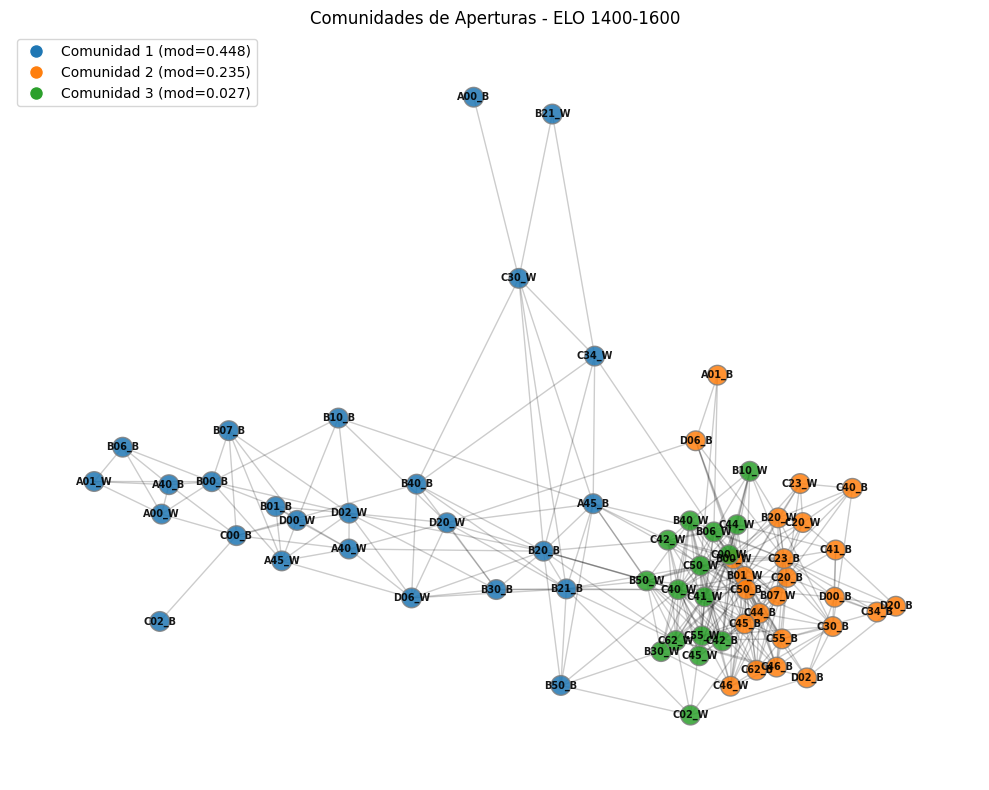


=== MÉTRICAS DE CADA COMUNIDAD ===

>>> Comunidad 1 (n=26):
Nodos principales: ['C30_W', 'C00_B', 'C34_W', 'A00_B', 'A00_W']

>>> Comunidad 2 (n=24):
Nodos principales: ['D02_B', 'C34_B', 'C45_B', 'C62_B', 'C55_B']

>>> Comunidad 3 (n=16):
Nodos principales: ['C55_W', 'B50_W', 'B40_W', 'B06_W', 'C42_W']

=== TABLA CONSOLIDADA DE MÉTRICAS POR COMUNIDAD ===
                         Comunidad 1  Comunidad 2  Comunidad 3
n_nodos                      26.0000      24.0000      16.0000
n_aristas                    78.0000     101.0000      65.0000
densidad_ponderada            0.0269       0.0549       0.0577
clustering_ponderado          0.1194       0.1638       0.1283
modularidad_ponderada         0.4480       0.2347       0.0462
transitividad_ponderada       0.5223       0.5511       0.6890
asortatividad_ponderada       0.1403      -0.1415      -0.1095


In [70]:
tabla_consolidada_1400_1600, dicc_comunidades_1400_1600 = analizar_coocurrencia_relevante(G_mayor_1400_1600, '1400-1600')

=== ANÁLISIS DE COOCURRENCIA - ELO 1600-1800 ===

=== FAMILIAS DE APERTURAS ===
Modularidad global: 0.444
Número total de comunidades: 5

--- Modularidad de cada comunidad ---

Familia 1:
  Tamaño: 26
  Miembros: ['D10_W', 'A04_W', 'C00_B', 'A00_B', 'D20_W', 'B00_B', 'A40_W', 'D00_W', 'A00_W', 'A43_W']...
  Cohesión: 0.231
  Modularidad (ponderada): 0.449

Familia 2:
  Tamaño: 25
  Miembros: ['B32_W', 'C30_W', 'C50_B', 'C44_B', 'C34_W', 'B50_W', 'C55_W', 'B06_W', 'C50_W', 'B21_W']...
  Cohesión: 0.373
  Modularidad (ponderada): 0.170

Familia 3:
  Tamaño: 18
  Miembros: ['D02_B', 'C34_B', 'C45_B', 'C62_B', 'C55_B', 'C21_B', 'C23_B', 'C42_B', 'D20_B', 'C20_W']...
  Cohesión: 0.451
  Modularidad (ponderada): 0.202

Familia 4:
  Tamaño: 9
  Miembros: ['B50_B', 'A43_B', 'B30_B', 'A45_B', 'B20_B', 'B22_B', 'B21_B', 'B32_B', 'A02_W']...
  Cohesión: 0.667
  Modularidad (ponderada): 0.012

Familia 5:
  Tamaño: 6
  Miembros: ['C21_W', 'B22_W', 'C02_B', 'C01_W', 'C02_W', 'B12_W']...
  Cohesión: 

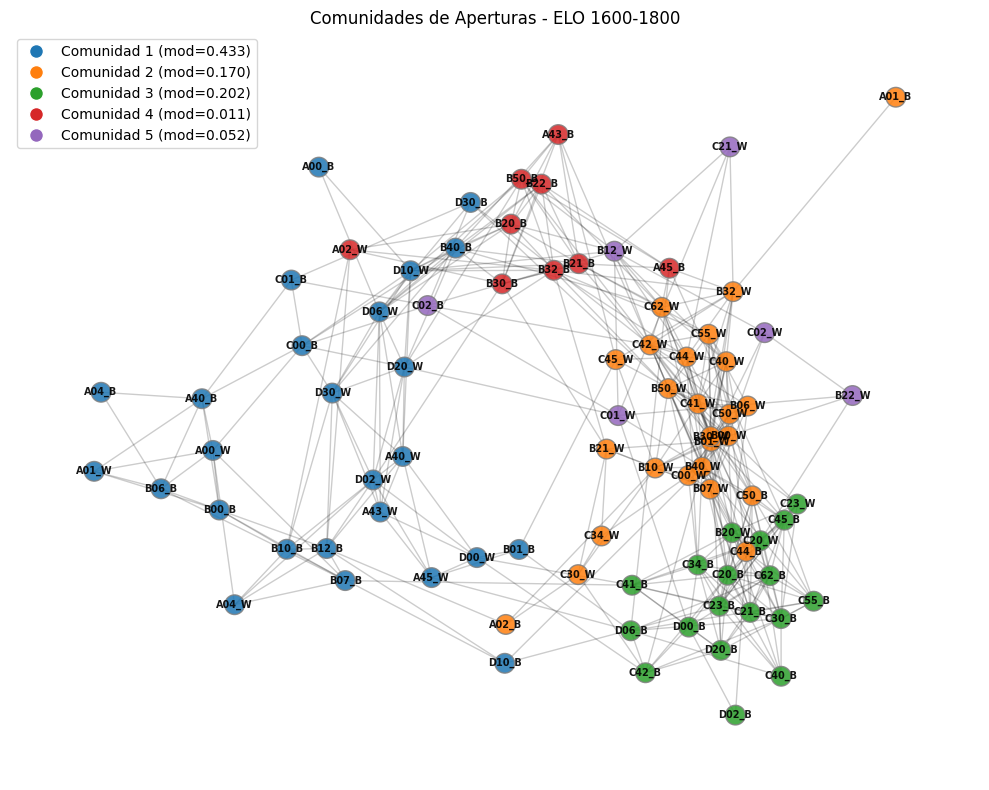


=== MÉTRICAS DE CADA COMUNIDAD ===

>>> Comunidad 1 (n=26):
Nodos principales: ['C00_B', 'A00_B', 'B12_B', 'A00_W', 'A40_W']

>>> Comunidad 2 (n=25):
Nodos principales: ['C30_W', 'C34_W', 'B50_W', 'B06_W', 'C62_W']

>>> Comunidad 3 (n=18):
Nodos principales: ['D02_B', 'C40_B', 'C34_B', 'C23_W', 'C20_B']

>>> Comunidad 4 (n=9):
Nodos principales: ['B50_B', 'A43_B', 'B30_B', 'A45_B', 'B20_B']

>>> Comunidad 5 (n=6):
Nodos principales: ['C21_W', 'C02_W', 'C02_B', 'B22_W', 'C01_W']

=== TABLA CONSOLIDADA DE MÉTRICAS POR COMUNIDAD ===
                         Comunidad 1  Comunidad 2  Comunidad 3  Comunidad 4  \
n_nodos                      26.0000      25.0000      18.0000       9.0000   
n_aristas                    75.0000     112.0000      69.0000      24.0000   
densidad_ponderada            0.0328       0.0397       0.0571       0.1051   
clustering_ponderado          0.1737       0.1142       0.1373       0.2192   
modularidad_ponderada         0.4287       0.1702       0.2019      

In [71]:
tabla_consolidada_1600_1800, dicc_comunidades_1600_1800=analizar_coocurrencia_relevante(G_mayor_1600_1800, '1600-1800')

## Subcomunidades dentro de la red 1400_1600

In [72]:
def obtener_comunidad_especifica(diccionario_comunidades, numero_comunidad):
    clave = f'Comunidad {numero_comunidad}'
    if clave not in diccionario_comunidades:
        print(f"Error: {clave} no encontrada en el diccionario.")
        return None

    nodos = diccionario_comunidades[clave]
    print(f"=== {clave} ===")
    print(f"Tamaño: {len(nodos)} nodos")
    print(f"Nodos: {nodos}")

    return {
        'numero': numero_comunidad,
        'nodos': list(nodos),
        'tamaño': len(nodos)
    }

In [73]:
comunidad_1 = obtener_comunidad_especifica(dicc_comunidades_1400_1600, numero_comunidad=1)

=== Comunidad 1 ===
Tamaño: 26 nodos
Nodos: ['C30_W', 'C00_B', 'C34_W', 'B50_B', 'A00_B', 'D20_W', 'A00_W', 'B06_B', 'B00_B', 'A40_W', 'D00_W', 'B21_W', 'C02_B', 'D02_W', 'B40_B', 'B07_B', 'A40_B', 'B01_B', 'B30_B', 'A01_W', 'B10_B', 'A45_B', 'B20_B', 'B21_B', 'A45_W', 'D06_W']


In [74]:
G_mayor_1400_1600_comunidad_1 = G_mayor_1400_1600.subgraph(comunidad_1['nodos']).copy()

=== ANÁLISIS DE COOCURRENCIA - ELO 1400-1600 Comunidad_1 ===

=== FAMILIAS DE APERTURAS ===
Modularidad global: 0.415
Número total de comunidades: 3

--- Modularidad de cada comunidad ---

Familia 1:
  Tamaño: 12
  Miembros: ['C30_W', 'C34_W', 'B40_B', 'B50_B', 'A00_B', 'D20_W', 'B30_B', 'A45_B', 'B20_B', 'B21_W']...
  Cohesión: 0.470
  Modularidad (ponderada): 0.262

Familia 2:
  Tamaño: 9
  Miembros: ['D02_W', 'C00_B', 'B07_B', 'B01_B', 'B10_B', 'A40_W', 'D00_W', 'C02_B', 'A45_W']...
  Cohesión: 0.528
  Modularidad (ponderada): 0.120

Familia 3:
  Tamaño: 5
  Miembros: ['A01_W', 'B00_B', 'A00_W', 'B06_B', 'A40_B']...
  Cohesión: 1.000
  Modularidad (ponderada): 0.000


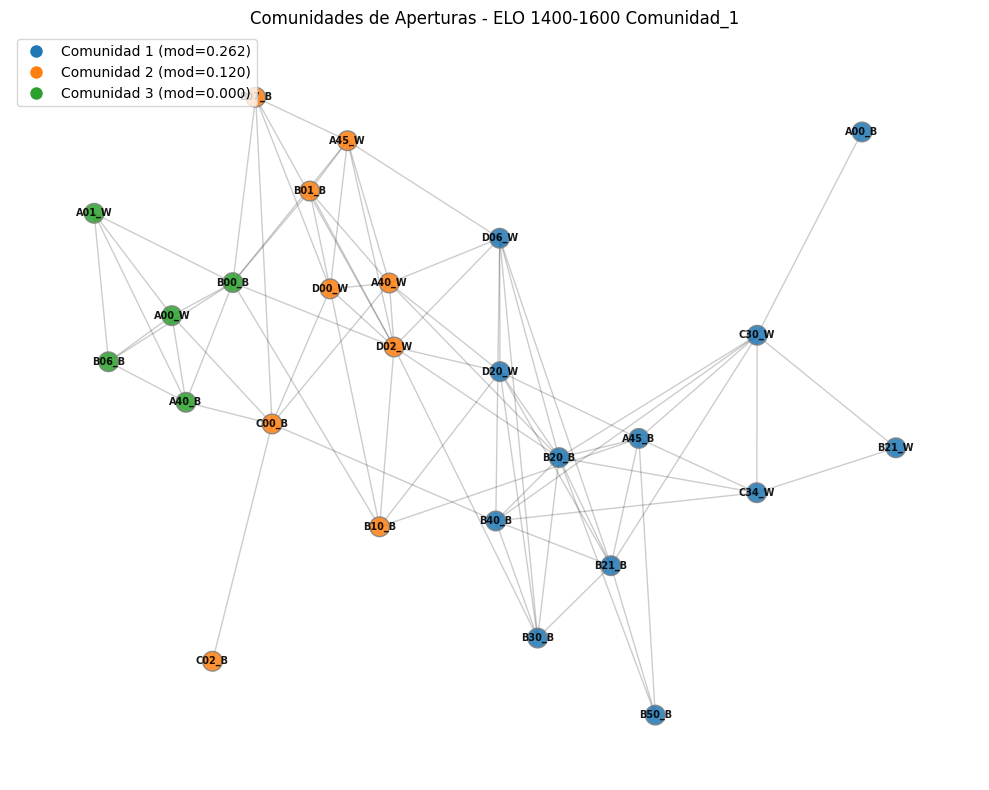


=== MÉTRICAS DE CADA COMUNIDAD ===

>>> Comunidad 1 (n=12):
Nodos principales: ['C30_W', 'B40_B', 'C34_W', 'B50_B', 'A00_B']

>>> Comunidad 2 (n=9):
Nodos principales: ['D02_W', 'C00_B', 'B07_B', 'B01_B', 'B10_B']

>>> Comunidad 3 (n=5):
Nodos principales: ['A40_B', 'A01_W', 'B00_B', 'B06_B', 'A00_W']

=== TABLA CONSOLIDADA DE MÉTRICAS POR COMUNIDAD ===
                         Comunidad 1  Comunidad 2  Comunidad 3
n_nodos                      12.0000       9.0000       5.0000
n_aristas                    31.0000      19.0000      10.0000
densidad_ponderada            0.0754       0.0857       0.2392
clustering_ponderado          0.2061       0.1823       0.4335
modularidad_ponderada         0.2617       0.1204       0.0000
transitividad_ponderada       0.6507       0.6743       1.0000
asortatividad_ponderada      -0.2152      -0.1794      -0.2500


In [75]:
Com_1_1400_1600, dicc_comunidades_Com_1_1400_1600= analizar_coocurrencia_relevante(G_mayor_1400_1600_comunidad_1, '1400-1600 Comunidad_1')